In [1]:
# this is used to analyse the rotation of the halo with K-giants

import ipywidgets as widgets
%matplotlib inline
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import math
import PyAstronomy as PA
from PyAstronomy import pyasl as PAP
from scipy import signal
import scipy.optimize as SO
import random
import galpy.util.bovy_coords as gub
import astropy.io.fits as fits
from matplotlib import cm
import scipy.ndimage.filters  as snf
import emcee
import VRR_common as VC

In [2]:
# aaa = np.random.normal(0,1,100)
# cc = np.concatenate([aaa,aaa+20])
# # print(aaa)
# # print(cc)
# Mpopt,Mpcov = VC.gauss2_model(cc)

In [3]:
def Gaussian2(x,a1,m1,s1,a2,m2,s2):
    return a1*np.exp(-((x-m1)/s1)**2)+a2*np.exp(-((x-m2)/s2)**2)
def Gaussian(x,a,m,s):
    return a*np.exp(-((x-m)/s)**2)

In [4]:
def kernalfunc(xc,yc,xarr,yarr,disp_x,disp_y):
#     wv = np.sum(tnp.exp(-(xarr-xc)**2/disp_x-(yarr-yc)**2/disp_y))
    wv = np.sum(\
        (2-(xarr-xc)**2/(disp_x**2)-(yarr-yc)**2/(disp_y**2)) * \
         np.exp(-0.5*(xarr-xc)**2/(disp_x**2)-0.5*(yarr-yc)**2/(disp_y**2))\
               )
        
    return wv
    
#      current only for gaussian
def wavetrans(x,y,min_x,max_x,min_y,max_y,nx,ny,disp_x,disp_y):
    N = len(x)
    wght = np.zeros(N)
    bins_x = np.linspace(min_x,max_x,nx+1)
    bins_y = np.linspace(min_y,max_y,ny+1)
    stp_x = (max_x-min_x)/nx
    stp_y = (max_y-min_y)/ny
    for i in range(0,N):
        wght[i] = kernalfunc(x[i],y[i],x,y,disp_x*stp_x,disp_y*stp_y)
    wvnw,xedges,yedges = np.histogram2d(x,y,bins=(bins_x,bins_y),weights=wght)
    wvn,xedges,yedges = np.histogram2d(x,y,bins=(bins_x,bins_y))
#     print("___",len(bins_x[:-1]),np.max(wght))
    return wvnw,wvn,bins_x[:-1]+stp_x*0.5,bins_y[:-1]+stp_y*0.5
    

In [5]:
dpath = "/Users/htian/Documents/work/data/rothalo/"
ppath = "/Users/htian/Documents/work/plots/rothalo/"
fn = "dr5GaiaDR2_v1_all_photos_EWs_dist_halo_feh_le_m1_TRUEKGIANT_NODUPLICATED"
# fn = "dr5GaiaDR2_v1_all_photos_EWs_dist_halo_feh_le_m1_TRUEKGIANT_NODUPLICATED"
d_fmt = ".fits"
# fn_tag = ""#"vlsr218_"#"dGaia_" #"vlsr218_"

In [6]:
# in LSR frame
U_sun, V_sun, W_sun = 11.1, 12.24, 7.25
X_sun = 8.3
V_LSR = 232#232#218#232
fn_tag = "r2"#"vlsr218_"#"dGaia_" #"vlsr218_"  240 Reid et al 2014 

In [7]:
DtG = fits.open(dpath+fn+d_fmt)
dataG = DtG[1].data
# ra_G, dec_G = dataG["ra_epoch2000"],dataG["dec_epoch2000"]
# br_rp, MagG, a_g = dataG["bp_rp"],dataG["phot_g_mean_mag"],dataG["a_g_val"]
# rvG, rvGe = dataG["radial_velocity"],dataG["radial_velocity_error"]
# rvL, rvLe = dataG["rv"],dataG["rv_err"]

In [8]:
for nm in DtG[1].columns:
    print(nm)

name = 'obsid_1'; format = 'J'; null = -2147483648
name = 'ra_epoch2000_1'; format = 'D'; unit = 'deg'
name = 'dec_epoch2000_1'; format = 'D'; unit = 'deg'
name = 'errHalfMaj_1'; format = 'E'; unit = 'arcsec'
name = 'errHalfMin_1'; format = 'E'; unit = 'arcsec'
name = 'errPosAng_1'; format = 'E'; unit = 'deg'
name = 'source_id_1_1'; format = 'K'; null = -9223372036854775808
name = 'ra_x_1'; format = 'D'; unit = 'deg'
name = 'ra_error_1'; format = 'D'; unit = 'mas'
name = 'dec_x_1'; format = 'D'; unit = 'deg'
name = 'dec_error_1'; format = 'D'; unit = 'mas'
name = 'parallax_1'; format = 'D'; unit = 'mas'
name = 'parallax_error_1'; format = 'D'; unit = 'mas'
name = 'pmra_1'; format = 'D'; unit = 'mas/yr'
name = 'pmra_error_1'; format = 'D'; unit = 'mas/yr'
name = 'pmdec_1'; format = 'D'; unit = 'mas/yr'
name = 'pmdec_error_1'; format = 'D'; unit = 'mas/yr'
name = 'duplicated_source_1'; format = 'L'
name = 'phot_g_mean_flux_1'; format = 'D'; unit = 'e-/s'
name = 'phot_g_mean_flux_error_1'

In [9]:
ra_Ga, dec_Ga = dataG["ra_epoch2000_1"],dataG["dec_epoch2000_1"]
br_rpa, MagGa, a_ga = dataG["bp_rp_1"],dataG["phot_g_mean_mag_1"],dataG["a_g_val_1"]
rvGa, rvGea = dataG["radial_velocity_1"],dataG["radial_velocity_error_1"]
rvLa, rvLea = dataG["rv_1"],dataG["rv_err_1"]
feha = dataG["feh_1"]
pmra_Gae, pmdec_Gae = dataG["pmra_error_1"],dataG["pmdec_error_1"]
pmra_Ga, pmdec_Ga = dataG["pmra_1"],dataG["pmdec_1"]
feha,fehea = dataG["feh_1"],dataG["feh_err_1"]
dista, dista_15, dista_85,dista_len = dataG["r_est_1"],dataG["r_lo_1"],dataG["r_hi_1"],dataG["r_len_1"]
distae = 0.5*(dista_85 - dista_15)
prlxa, prlxae = dataG["parallax_1"],dataG["parallax_error_1"]
distLa,distLa_15,distLa_85 = dataG["DistK50_RJCE_1"],dataG["DistK15_RJCE_1"],dataG["DistK85_RJCE_1"]
snrga = dataG["snrg_1"]

In [10]:
ind_halo = (pmra_Ga ==pmra_Ga) & ( pmdec_Ga ==pmdec_Ga) &\
(rvGa==rvGa) & (rvGea==rvGea) & (dista==dista) #& (snrga>10)
ra_Gt,dec_Gt = ra_Ga[ind_halo],dec_Ga[ind_halo]
pmra_Gt,pmdec_Gt = pmra_Ga[ind_halo],pmdec_Ga[ind_halo]
pmra_eGt,pmdec_eGt = pmra_Gae[ind_halo],pmdec_Gae[ind_halo]
rvGt, rvGet = rvGa[ind_halo], rvGea[ind_halo]
rvLt, rvLet = rvLa[ind_halo], rvLea[ind_halo]
feht,fehet = feha[ind_halo],fehea[ind_halo]
distt, distet = dista[ind_halo]/1000, distae[ind_halo]/1000
# distt, distet = 1/prlxa[ind_halo], prlxae[ind_halo]/(prlxa[ind_halo]**2)
prlxt, prlxet = prlxa[ind_halo], prlxae[ind_halo]
distLt,distL_15t,distL_85t = distLa[ind_halo],distLa_15[ind_halo],distLa_85[ind_halo]
print(len(feht))
#--------------------------------------------------------
ind_halo0 =  (distet/distt<0.2) & (distt<4) 
ra_G,dec_G = ra_Gt[ind_halo0],dec_Gt[ind_halo0]
pmra_G,pmdec_G = pmra_Gt[ind_halo0],pmdec_Gt[ind_halo0]
pmra_eG,pmdec_eG = pmra_eGt[ind_halo0],pmdec_eGt[ind_halo0]
rvG, rvGe = rvGt[ind_halo0], rvGet[ind_halo0]
rvL, rvLe = rvLt[ind_halo0], rvLet[ind_halo0]
feh,fehe = feht[ind_halo0],fehet[ind_halo0]
dist, diste = distt[ind_halo0], distet[ind_halo0]
prlx, prlxe = prlxt[ind_halo0], prlxet[ind_halo0]
distL,distL_15,distL_85 = distLt[ind_halo0],distL_15t[ind_halo0],distL_85t[ind_halo0]
print(len(feh[(pmra_eG<0.1) & (pmdec_eG<0.1)]))
print(len(feh[rvGe<2]))
print(len(feh))

6660
3517
3054
3827


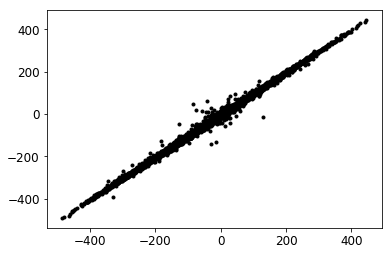

5.4738530474061315


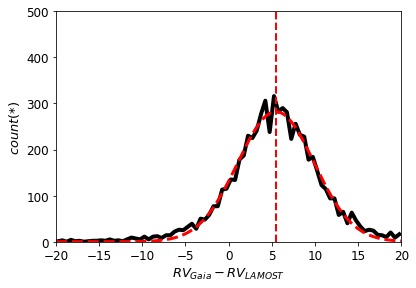

In [11]:
plt.plot(rvGt,rvLt,'k.')
plt.show()
bins_resrv = np.linspace(-20,20,81)
hy_resv,hx_resv = np.histogram(rvGt-rvLt,bins=bins_resrv)
poptrrv,pcovrrv = SO.curve_fit(Gaussian,hx_resv[:-1]+0.5*(hx_resv[1]-hx_resv[0]),\
                               hy_resv*1.0,bounds=([10,0,0],\
                    [1000,20,40]))
sxx = np.linspace(-20,20,10001)
fig =plt.figure(figsize=(6,4))
ax = fig.add_axes([0.15,0.15,0.8,0.8])
plt.plot(hx_resv[:-1]+0.5*(hx_resv[1]-hx_resv[0]),hy_resv,'k-',linewidth=4)
plt.plot(sxx,Gaussian(sxx,*poptrrv),'r--',linewidth=3)
plt.plot([poptrrv[1],poptrrv[1]],[0,500],"r--",linewidth=2)
plt.axis([-20,20,0,500])
plt.xlabel("$RV_{Gaia}-RV_{LAMOST}$",fontsize=13)
plt.ylabel("$count(*)$",fontsize=13)
plt.savefig(ppath+fn_tag+"hist_resRV.eps")
print(poptrrv[1])

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4 ]
[2604  563  226  150   97   68   39   37]


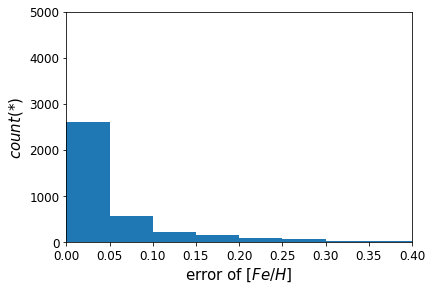

In [12]:
bins_fehe = np.linspace(0,0.4,9)
hyfehe,hxfehe = np.histogram(fehe,bins = bins_fehe)
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.15,0.15,0.8,0.8])
ax.bar(hxfehe[:-1],hyfehe,width=0.1)
ax.set_xlabel("error of $[Fe/H]$",fontsize=15)
ax.set_ylabel("$count(*)$",fontsize=15)
ax.set_xlim([0,0.4])
ax.set_ylim([0,5000])
plt.savefig(ppath+fn_tag+"Hist_FeHe.eps")
print(hxfehe)
print(hyfehe)

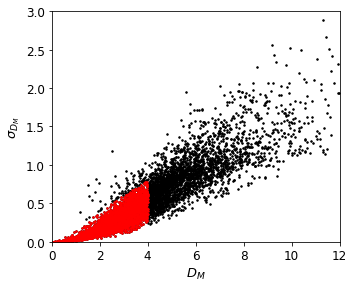

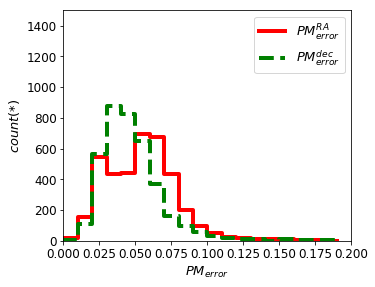

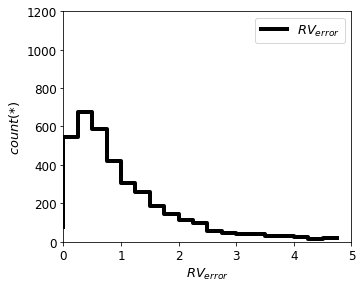

In [13]:
bins_resD = np.linspace(-2,2,41)
res_GmM = 1/prlxt-distt
fig = plt.figure(figsize=(5,4))
ax = fig.add_axes([0.15,0.15,0.80,0.8])
plt.plot(distt,distet,'ko',markersize=1.5)
plt.plot(dist,diste,'ro',markersize=1.5)
# plt.colorbar()
plt.axis([0,12,0,3])
plt.xlabel("$D_M$",fontsize=13)
plt.ylabel("$\sigma_{D_M}$",fontsize=13)
plt.savefig(ppath+fn_tag+"D_eD.eps")
plt.show()
fig = plt.figure(figsize=(5,4))
ax = fig.add_axes([0.15,0.15,0.80,0.8])
bins_pme = np.linspace(0,0.2,21)
hy_ra,hx_ra = np.histogram(pmra_eG,bins=bins_pme)
hy_dec,hx_dec = np.histogram(pmdec_eG,bins=bins_pme)
plt.step(hx_ra[:-1],hy_ra,color='r',label="$PM_{error}^{RA}$",linestyle='-',linewidth=4)
plt.step(hx_dec[:-1],hy_dec,color='g',label="$PM_{error}^{dec}$",linestyle='--',linewidth=4)
plt.xlabel("$PM_{error}$",fontsize=13)
plt.ylabel("$count(*)$",fontsize=13)
plt.legend(loc=1,fontsize=13)
plt.axis([0,0.2,0,1500])
plt.savefig(ppath+fn_tag+"hist_pme.eps")
plt.show()
fig = plt.figure(figsize=(5,4))
ax = fig.add_axes([0.15,0.15,0.80,0.8])
bins_rve = np.linspace(0,5,21)
hy_rve,hx_rve = np.histogram(rvGe,bins=bins_rve)
plt.step(hx_rve[:-1],hy_rve,color='k',label="$RV_{error}$",linestyle='-',linewidth=4)
plt.xlabel("$RV_{error}$",fontsize=13)
plt.ylabel("$count(*)$",fontsize=13)
plt.legend(loc=1,fontsize=13)
plt.axis([0,5,0,1200])
plt.savefig(ppath+fn_tag+"hist_rve.eps")

In [14]:
print(np.median(rvGe))

1.01


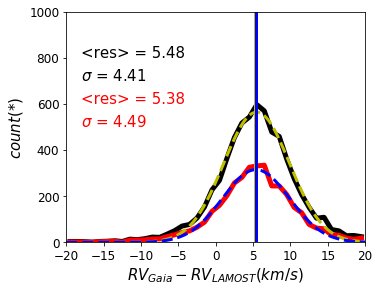

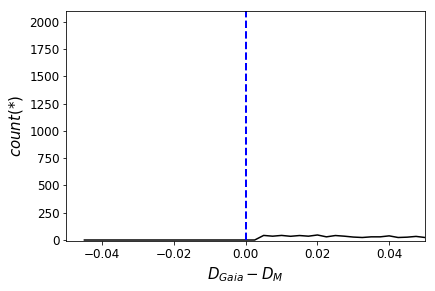

3827


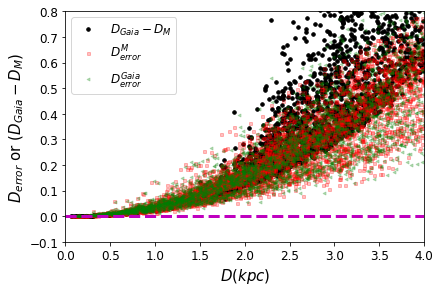

In [15]:
bins_rv = np.linspace(-20,20,41)
hy,hx = np.histogram(rvGt-rvLt,bins=bins_rv)
hys,hxs = np.histogram(rvG-rvL,bins=bins_rv)
fig = plt.figure(figsize=(5,4))
ax = fig.add_axes([0.15,0.15,0.83,0.8])
plt.plot(hx[:-1]+0.5,hy,'k',linewidth = 5)
plt.plot(hxs[:-1]+0.5,hys,'r-',linewidth = 5)
poptc,pcovc = SO.curve_fit(Gaussian,hx[:-1]+0.5,hy*1.0,bounds=([10,0,0],\
                    [1000,20,40]))
poptcs,pcovcs = SO.curve_fit(Gaussian,hxs[:-1]+0.5,hys*1.0,bounds=([10,0,0],\
                    [1000,20,40]))
xxxxL = np.linspace(-20,20,10001)
plt.plot(xxxxL,Gaussian(xxxxL,*poptc),'y--',linewidth=3)
plt.plot(xxxxL,Gaussian(xxxxL,*poptcs),'b--',linewidth=3)
plt.plot([poptcs[1],poptcs[1]],[0,1000],'y-',linewidth=4)
plt.plot([poptcs[1],poptcs[1]],[0,1000],'b-',linewidth=3)
avv,sigv = round(poptc[1],2),round(poptc[2]/np.sqrt(2),2)
avvs,sigvs = round(poptcs[1],2),round(poptcs[2]/np.sqrt(2),2)
plt.text(-18,800,"<res> = {avv}".format(**locals()),fontsize=15,color="k")
plt.text(-18,700,"$\sigma$ = {sigv}".format(**locals()),fontsize=15,color="k")
plt.text(-18,600,"<res> = {avvs}".format(**locals()),fontsize=15,color="r")
plt.text(-18,500,"$\sigma$ = {sigvs}".format(**locals()),fontsize=15,color="r")
plt.xlabel("$RV_{Gaia}-RV_{LAMOST}(km/s)$",fontsize=15)
plt.ylabel("$count(*)$",fontsize=15)
plt.axis([-20,20,0,1000])
plt.savefig(ppath+fn_tag+"RV_res.eps")
plt.show()
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.12,0.15,0.83,0.8])
bins_dist = np.linspace(-0.05,0.05,41)
hy,hx = np.histogram(1/prlx-dist,bins = bins_dist)
plt.plot(hx[:-1]+0.005,hy,'k-')
plt.plot([0,0],[0,10000],'b--',linewidth=2)
plt.xlabel("$D_{Gaia}-D_{M}$",fontsize=15)
plt.ylabel("$count(*)$",fontsize=15)
plt.axis([-0.05,0.05,-10,2100])
plt.savefig(ppath+fn_tag+"Dist_res.eps")
plt.show()
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.12,0.15,0.83,0.8])
res_dist = 1/prlx-dist
bins_resd = np.linspace(0,1,11)
plt.plot(dist,res_dist,'k.',markersize=7,label="$D_{Gaia}-D_{M}$")
plt.plot(dist,diste,'rs',markersize=3,alpha=0.25,label="$D_{error}^M$")
plt.plot(1/prlx,1/prlx*prlxe/prlx,'g<',markersize=3,alpha=0.25,label="$D_{error}^{Gaia}$")
plt.plot([0,4],[0,0],'m--',linewidth = 3)
plt.axis([0,4,-0.1,0.8])
plt.xlabel("$D(kpc)$",fontsize=15)
plt.ylabel("$D_{error}$ or $(D_{Gaia}-D_{M})$",fontsize=15)
plt.legend(loc=2,fontsize=12)
plt.savefig(ppath+fn_tag+"Dist_comparison.eps")
print(len(rvG))

[-2.5 -2.4 -2.3 -2.2 -2.1 -2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2
 -1.1 -1. ]


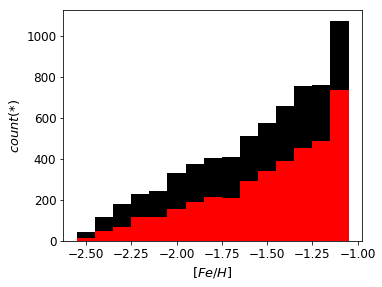

In [16]:
bins_feh=np.linspace(-2.5,-1.,16)
print(bins_feh)
fig = plt.figure(figsize=(5,4))
ax = fig.add_axes([0.15,0.15,0.83,0.8])
hyfeh,hxfeh = np.histogram(feht,bins=bins_feh)
hyfehs,hxfehs = np.histogram(feh,bins=bins_feh)
plt.bar(hxfeh[:-1],hyfeh[:],width=0.1,color='k')
plt.bar(hxfehs[:-1],hyfehs[:],width=0.1,color='r')
plt.xlabel("$[Fe/H]$",fontsize=13)
plt.ylabel("$count(*)$",fontsize=13)
plt.savefig(ppath+fn_tag+"hist_feh.eps")

0
0
0.018


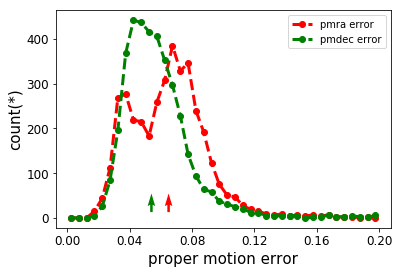

In [17]:
bins_pme = np.linspace(0,0.2,41)
hy_pmrae,hx_pmrae = np.histogram(pmra_eG,bins=bins_pme)
hy_pmdece,hx_pmdece = np.histogram(pmdec_eG,bins=bins_pme)
fig = plt.figure(figsize=(6,4))
plt.plot(hx_pmrae[:-1]+(bins_pme[1]-bins_pme[0])/2,hy_pmrae,'ro--',label='pmra error',linewidth=3)
plt.plot(hx_pmdece[:-1]+(bins_pme[1]-bins_pme[0])/2,hy_pmdece,'go--',label='pmdec error',linewidth=3)
per_pmrae = np.percentile(pmra_eG,(16,50,84))
per_pmdece = np.percentile(pmdec_eG,(16,50,84))
plt.quiver(per_pmrae[1],[13],[0],[250],color='r')
plt.quiver(per_pmdece[1],[13],[0],[250],color='g')
plt.legend(loc=1)
plt.xlabel("proper motion error",fontsize=15)
plt.ylabel("count(*)",fontsize=15)
print(len(pmdec_eG[pmdec_eG<0.]))
print(len(pmdec_eG[pmra_eG<0.]))
print(np.min(pmdec_eG))
plt.xticks(np.linspace(0,0.2,6))
plt.savefig(ppath+"hist_PMe.pdf")


In [18]:
llbb = gub.radec_to_lb(ra_G,dec_G,degree=True)
# centered at LSR, with galactic center at (X_sun,0,0)kpc
xyz = gub.lbd_to_XYZ(llbb[:,0],llbb[:,1],dist,degree=True)  
pmllbb = gub.pmrapmdec_to_pmllpmbb(pmra_G,pmdec_G,ra_G,dec_G,degree=True)
vxvyvz = gub.vrpmllpmbb_to_vxvyvz(rvG,pmllbb[:,0],pmllbb[:,1],llbb[:,0],llbb[:,1],\
                                  dist,degree=True)
# vrvtvz0 = gub.vxvyvz_to_galcencyl(vxvyvz[:,0],vxvyvz[:,1],vxvyvz[:,2],xyz[:,0],\
#                                   X_sun-xyz[:,1],xyz[:,2],[0,220,0])
# here the sun's uvw in GC frame, XYZ in gc frame, UVW in LSR frame
vrvtvz = gub.vxvyvz_to_galcencyl(vxvyvz[:,0],vxvyvz[:,1],vxvyvz[:,2],\
                                 X_sun-xyz[:,0],xyz[:,1],xyz[:,2],[U_sun*(-1),V_LSR+V_sun,W_sun])  
# double checked in vxvyvz_to_galcencyl UVW are relative to the LSR, 
# xyz relative to the galatic center

# VgsrG = rvG+9.58*np.cos(llbb[:,1]*math.pi/180)*np.cos(llbb[:,0]*math.pi/180)+ \
#     (220+10.52)*np.cos(llbb[:,1]*math.pi/180)*np.sin(llbb[:,0]*math.pi/180)+ \
#     7.01*np.sin(llbb[:,1]*math.pi/180)
# print(vrvtvz[:3,:3])
# print("----------")
# print(vrvtvz0[:3,:3])

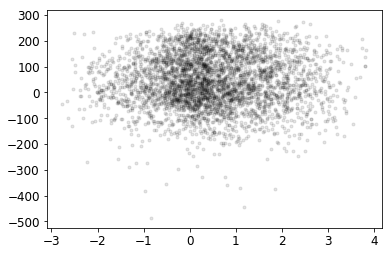

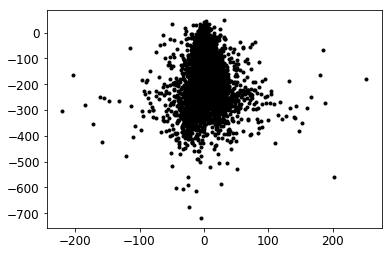

In [19]:
plt.plot(xyz[:,1],vxvyvz[:,1]+232,'k.',alpha=0.1)
plt.show()
plt.plot(pmllbb[:,0],vxvyvz[:,1],'k.')

***************************DB
[ 0.16457617  0.26953475 -0.94882332]
[0.75116485 0.58919175 0.29766499]
[ 0.63926994 -0.76171129 -0.1054981 ]
***************************
0.009274604702713974 0.0023524933534986438 0.014138345084145146 ----------
-------------------------
[ 1.58735675  5.39776022 14.75809918]
[ 2.79970224 11.29529991 25.27272039]
[ 1.41751336  4.29751559 10.87858814]
-------------------------


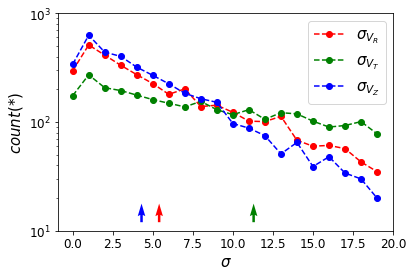

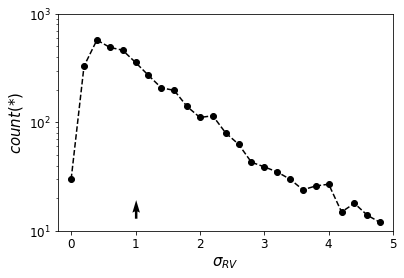

[ 1.02315031  5.54476967 16.44489958]
[  7.04801515  94.75598806 532.7310587 ]
3827
1914
[0.49 1.01 2.27]
[ 2.64370282 11.22729863 25.47273817]


In [20]:
output = np.zeros((len(vrvtvz[:,0]),4))
output[:,1:] = vrvtvz
output[:,0] = feh
np.savetxt(dpath+fn_tag+"fehvrvtvz.dat",output,fmt="%15.7f",delimiter=" ")

error_perp = dist*np.sqrt(pmra_eG**2+pmdec_eG**2)*4.74 + diste * np.sqrt(pmra_G**2+pmdec_G**2) *4.74
error_tot = np.sqrt(error_perp**2+rvGe**2)
import sys
sys.path.append('/Users/htian/Documents/GitHub/astroth/')
import dynath as dnt
R = np.sqrt((X_sun-xyz[:,0])**2+xyz[:,1]**2)
cost = (X_sun-xyz[:,0])/R
sint = xyz[:,1]/R
Us,Vs,Ws,Ues2,Ves2,Wes2,VRe2,VTe2,VZe2 = dnt.radecdrvpm(ra_G,dec_G,sint,cost,dist,rvG,pmra_G,pmdec_G,\
                                      diste,rvGe,pmra_eG,pmdec_eG)#,alpha_ngp=192.25,delta_ngp=27.4)
print(np.min(Ues2),np.min(Ves2),np.min(Wes2),'----------')
VRe,VTe,VZe = np.sqrt(VRe2),np.sqrt(VTe2),np.sqrt(VZe2)

per_VRe = np.percentile(VRe,(16,50,84))
per_VTe = np.percentile(VTe,(16,50,84))
per_VZe = np.percentile(VZe,(16,50,84))
print
print('-------------------------')
print(np.percentile(np.sqrt(VRe2),(16,50,84)))
print(np.percentile(np.sqrt(VTe2),(16,50,84)))
print(np.percentile(np.sqrt(VZe2),(16,50,84)))
print('-------------------------')

bins_ve = np.linspace(0,20,21)
hy_u,hx_u = np.histogram(VRe,bins=bins_ve)
hy_v,hx_v = np.histogram(VTe,bins=bins_ve)
hy_w,hx_w = np.histogram(VZe,bins=bins_ve)
fig = plt.figure(figsize=(6,4))
plt.plot(hx_u[:-1],hy_u,'ro--',label="$\sigma_{V_R}$")
plt.plot(hx_v[:-1],hy_v,'go--',label="$\sigma_{V_T}$")
plt.plot(hx_w[:-1],hy_w,'bo--',label="$\sigma_{V_Z}$")
# plt.plot(hx_rv[:-1],hy_rv,'ko--',label="$\sigma_{RV}$")
plt.quiver(per_VRe[1],[12],[0],[150],color='r')
plt.quiver(per_VTe[1],[12],[0],[150],color='g')
plt.quiver(per_VZe[1],[12],[0],[150],color='b')
plt.legend(fontsize=15)
plt.yscale("log")
plt.xlabel("$\sigma$",fontsize=15)
plt.ylabel("$count(*)$",fontsize=15)
plt.axis([-0.9,20,10,1000])
plt.savefig(ppath+"hist_vvver.pdf")
plt.show()
fig = plt.figure(figsize=(6,4))
bins_rve = np.linspace(0,5,26)
hy_rv,hx_rv = np.histogram(rvGe,bins=bins_rve)
per_RVe = np.percentile(rvGe,(16,50,84)) 
plt.plot(hx_rv[:-1],hy_rv,'ko--')
plt.quiver(per_RVe[1],[13],[0],[250],color='k')
# plt.legend(fontsize=15)
plt.xlabel("$\sigma_{RV}$",fontsize=15)
plt.ylabel("$count(*)$",fontsize=15)
plt.axis([-0.2,5,10,1000])
plt.yscale("log")
plt.savefig(ppath+"hist_RVe.pdf")
plt.show()
# plt.axis([0,15,0,10])
print(np.percentile(np.abs(VTe-VRe),(16,50,84)))
print(np.percentile(np.abs(Ues2-Ves2),(16,50,84)))
print(len(VTe))
print(len(VTe[VTe<11.30128574]))
print(np.percentile(rvGe,(16,50,84)))
print(np.percentile(np.sqrt(Ves2),(16,50,84)))

In [21]:
print(np.percentile(pmra_G,(16,50,84)))

[-17.66324  -3.208     8.55368]


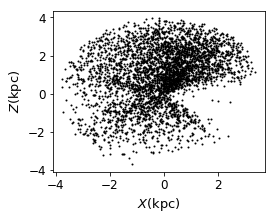

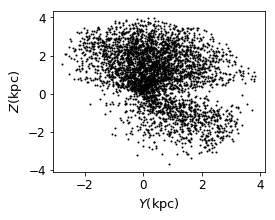

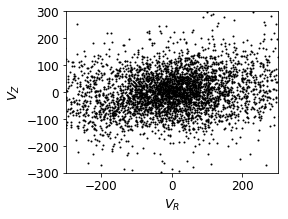

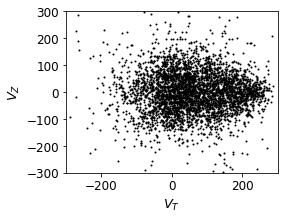

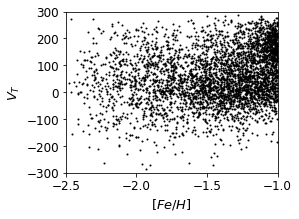

In [22]:
ind_core =  dist<1

fig = plt.figure(figsize=(4.2,2.8))
ax = fig.add_axes([0.2,0.17,0.7,0.8])
plt.plot(xyz[:,0],xyz[:,2],'ko',markersize=1)
# plt.plot(xyz[ind_core,0],xyz[ind_core,2],'ro',markersize=1)
plt.xlabel("$X$(kpc)",fontsize=13)
plt.ylabel("$Z$(kpc)",fontsize=13)
plt.savefig(ppath+fn_tag+"XZ.eps")
plt.show()

fig = plt.figure(figsize=(4.2,2.8))
ax = fig.add_axes([0.2,0.17,0.7,0.8])
plt.plot(xyz[:,1],xyz[:,2],'ko',markersize=1)
# plt.plot(xyz[ind_core,1],xyz[ind_core,2],'ro',markersize=1)
plt.xlabel("$Y$(kpc)",fontsize=13)
plt.ylabel("$Z$(kpc)",fontsize=13)
plt.savefig(ppath+fn_tag+"YZ.eps")
plt.show()

fig = plt.figure(figsize=(4.2,2.8))
ax = fig.add_axes([0.2,0.17,0.7,0.8])
plt.plot(vrvtvz[:,0],vrvtvz[:,2],'ko',markersize=1)
# plt.plot(vrvtvz[ind_core,0],vrvtvz[ind_core,2],'ro',markersize=1)
plt.xlabel("$V_{R}$",fontsize=13)
plt.ylabel("$V_{Z}$",fontsize=13)
plt.axis([-300,300,-300,300])
plt.savefig(ppath+fn_tag+"VRVZ.eps")
plt.show()

fig = plt.figure(figsize=(4.2,2.8))
ax = fig.add_axes([0.2,0.17,0.7,0.8])
plt.plot(vrvtvz[:,1],vrvtvz[:,2],'ko',markersize=1)
# plt.plot(vrvtvz[ind_core,1],vrvtvz[ind_core,2],'ro',markersize=1)
plt.xlabel("$V_{T}$",fontsize=13)
plt.ylabel("$V_{Z}$",fontsize=13)
plt.axis([-300,300,-300,300])
plt.savefig(ppath+fn_tag+"VTVZ.eps")
plt.show()

fig = plt.figure(figsize=(4.2,2.8))
ax = fig.add_axes([0.2,0.17,0.7,0.8])
plt.plot(feh,vrvtvz[:,1],'ko',markersize=1)
# plt.plot(vrvtvz[ind_core,1],vrvtvz[ind_core,2],'ro',markersize=1)
plt.xlabel("$[Fe/H]$",fontsize=13)
plt.ylabel("$V_{T}$",fontsize=13)
plt.axis([-2.5,-1,-300,300])
plt.savefig(ppath+fn_tag+"VT_FEH_S.eps")
plt.show()

In [23]:
# plt.plot(llbb[:,0],pmllbb[:,0],'r.',alpha=0.2)
# plt.show()
# plt.plot(llbb[:,0],rvG,'r.',alpha=0.2)
# plt.show()
# plt.plot(llbb[:,0],VgsrG,'r.',alpha=0.2)
# plt.show()
# plt.scatter(llbb[:,0],VgsrG,c=llbb[:,1],cmap='gist_rainbow')
# plt.colorbar()
# plt.show()
# plt.scatter(llbb[:,0],VgsrG,c=feh,cmap='gist_rainbow')
# plt.colorbar()
# plt.show()
# indd = dist<2
# plt.scatter(llbb[:,0],pmllbb[:,0]*dist[:],c=dist[:],cmap='gist_rainbow',vmax=10)
# plt.scatter(llbb[indd,0],pmllbb[indd,0]*dist[indd],c=dist[indd]*0+20,\
#             cmap='gist_rainbow',vmax=10)
# plt.colorbar()

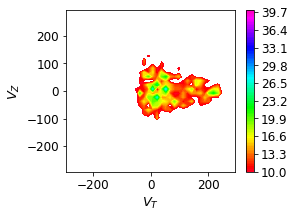

[3.81409276e+01 1.70608409e-13 4.68149696e+01 7.14300330e+01
 7.30980586e+01 1.61434169e+02]
[3.56588017 2.97250383 5.28633361 2.60749419 4.30348562 4.34104105]
-------------------------
[ 28.49456299  46.40507734 130.25017426  10.83819943   6.76020133
  29.74668243]
[1.30726406 3.50401171 4.52303295 1.87831521 3.69872455 6.43195898]
[14.92708485 -1.84920983 -2.8160004 ]
[-24. -18. -12.]


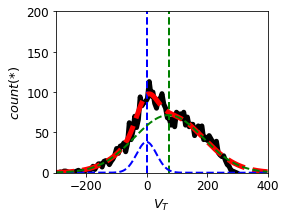

In [24]:
bin2_v = np.linspace(-300,300,41)
Hv,hxv,hyv = np.histogram2d(vrvtvz[:,1],vrvtvz[:,2],bins=(bin2_v,bin2_v))
fig = plt.figure(figsize=(4.2,2.8))
ax = fig.add_axes([0.2,0.17,0.7,0.8])
plt.contourf(hxv[:-1]+7.5,hxv[:-1]+7.5,Hv.T,levels=np.linspace(10,40,101),cmap="gist_rainbow")
plt.colorbar()
plt.xlabel("$V_{T}$",fontsize=13)
plt.ylabel("$V_{Z}$",fontsize=13)
plt.savefig(ppath+fn_tag+"VTVZ_contour.eps")
plt.show()

fig = plt.figure(figsize=(4.2,2.8))
ax = fig.add_axes([0.2,0.17,0.7,0.8])
bins_vt = np.linspace(-300,300,101)
hy,hx = np.histogram(vrvtvz[:,1],bins = bins_vt)
indout = np.abs(xyz[:,2])>2
hyo,hxo = np.histogram(vrvtvz[indout,1],bins = bins_vt)
plt.plot(hx[:-1]+(hx[1]-hx[0])*0.5,hy,'k-',linewidth=5)
# plt.plot(hxo[:-1]+(hxo[1]-hxo[0])*0.5,hyo,'m-',linewidth=5)
popt,pcov = SO.curve_fit(Gaussian2,hx[:-1],hy*1.0,bounds=([30,0,0,10,50,0],\
                    [500,200,10000,500,200,10000]))
popto,pcovo = SO.curve_fit(Gaussian2,hxo[:-1],hyo*1.0,bounds=([10,-200,0,10,-200,0],\
                    [500,200,10000,500,200,10000]))
xxxx = np.linspace(-500,500,100001)
plt.plot([popt[1],popt[1]],[0,10000],'b--',linewidth=2)
plt.plot([popt[4],popt[4]],[0,10000],'g--',linewidth=2)
plt.plot(xxxx,Gaussian2(xxxx,*popt),'r--',linewidth=5)
plt.plot(xxxx,Gaussian(xxxx,*popt[:3]),'b--',linewidth=2)
plt.plot(xxxx,Gaussian(xxxx,*popt[3:]),'g--',linewidth=2)
# plt.plot(xxxx,Gaussian2(xxxx,*popto),'y--',linewidth=5)
plt.axis([-50,50,0,200])
plt.axis([-300,400,0,200])
plt.xlabel("$V_T$",fontsize=13)
plt.ylabel("$count(*)$",fontsize=13)
plt.savefig(ppath+fn_tag+"hist_vt.eps")
print(popt)
print(np.sqrt(np.diag(pcov)))
print('-------------------------')
print(popto)
print(np.sqrt(np.diag(pcovo)))
resxs = hy-Gaussian2(hx[:-1],*popt)
indxs = (hx[:-1]<-10) & (hx[:-1]>-30) 
print(resxs[indxs])
print(hx[:-1][indxs])

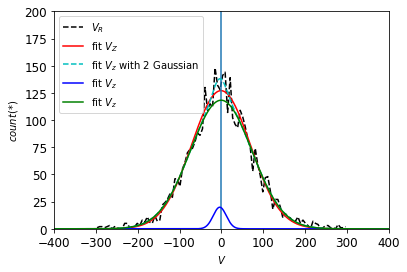

parameter: [ 71.21070017   5.09232046 172.77118337]
sigma: [ 2.76251435 10.80001255 22.44032748]
parameter: [127.07280541  -0.9228212   99.41969533]
sigma: [3.84319248 1.56834029 3.13668445]
[ 36.90014146  -7.50171222 261.88740258  42.51380351  13.4598272
  90.42002445]
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
[ 19.85434984  -3.84985634  22.14049525 118.27810113  -0.59988861
 104.11424127]


In [25]:
R = np.sqrt((X_sun-xyz[:,0])**2+xyz[:,1]**2)
Z = xyz[:,2]

hyxxr,hxxxr = np.histogram(vrvtvz[:,0],bins = bins_vt)
hyxxz,hxxxz = np.histogram(vrvtvz[:,2],bins = bins_vt)
plt.plot(hxxxr[:-1]+0.5*(hxxxr[1]-hxxxr[0]),hyxxz,'k--',label="$V_R$")
# plt.plot(hxxxz[:-1]+0.5*(hxxxz[1]-hxxxz[0]),hyxxz,'k--',label="$V_Z$")
poptr,pcovr = SO.curve_fit(Gaussian,hxxxr[:-1]+0.5*(hxxxr[1]-hxxxr[0]),hyxxr,bounds=([0,-50,0],[300,50,600]))
poptz,pcovz = SO.curve_fit(Gaussian,hxxxz[:-1]+0.5*(hxxxz[1]-hxxxz[0]),hyxxz,bounds=([0,-50,0],[300,50,600]))

poptr2,pcovr2 = SO.curve_fit(Gaussian2,hxxxr[:-1]+0.5*(hxxxr[1]-hxxxr[0]),hyxxr,\
                           bounds=([0,-50,100,0,-50,50],[300,50,600,300,50,600]))
poptz2,pcovz2 = SO.curve_fit(Gaussian2,hxxxz[:-1]+0.5*(hxxxz[1]-hxxxz[0]),hyxxz,\
                           bounds=([0,-50,20,0,-50,20],[300,50,600,300,50,600]))


sxxv = np.linspace(-400,400,1000001)
plt.plot(sxxv,Gaussian(sxxv,*poptz),'r-',label="fit $V_Z$")

# plt.plot(sxxv,Gaussian(sxxv,*poptz),'g-',label="fit $V_Z$")
plt.plot([0,0],[0,300])

plt.plot(sxxv,Gaussian2(sxxv,*poptz2),'c--',label="fit $V_z$ with 2 Gaussian")
plt.plot(sxxv,Gaussian(sxxv,*poptz2[:3]),'b-',label="fit $V_z$")
plt.plot(sxxv,Gaussian(sxxv,*poptz2[3:]),'g-',label="fit $V_z$")
plt.axis([-400,400,0,200])
plt.legend()
plt.xlabel("$V$")
plt.ylabel("$count(*)$")
plt.show()
print("parameter:",poptr)
print("sigma:",np.diag(pcovr))
print("parameter:",poptz)
print("sigma:",np.diag(pcovz))

# xyzgc = np.zeros_like(xyz)
# xyzgc[:,0] = 8-xyz[:,0]
# xyzgc[:,1] = xyz[:,1]
# xyzgc[:,2] = xyz[:,2]
# vlvbvr = np.zeros_like(vrvtvz)
# vlvbvr[:,0] = vrvtvz[:,1]
# vlvbvr[:,1] = vrvtvz[:,2]*R/np.sqrt(R**2+Z**2) - vrvtvz[:,0]*Z/np.sqrt(R**2+Z**2)
# vlvbvr[:,2] = vrvtvz[:,2]*Z/np.sqrt(R**2+Z**2) + vrvtvz[:,0]*R/np.sqrt(R**2+Z**2)

# hy_l1,hx_l1 = np.histogram(vlvbvr[:,0],bins = bins_vt)
# hy_b1,hx_b1 = np.histogram(vlvbvr[:,1],bins = bins_vt)
# hy_r1,hx_r1 = np.histogram(vlvbvr[:,2],bins = bins_vt)

# poptb,pcovb = SO.curve_fit(Gaussian2,hx_b1[:-1]+0.5*(hx_b1[1]-hx_b1[0]),hy_b1,\
#                            bounds=([0,-50,0,0,-50,0],[300,50,600,300,50,600]))
# poptr,pcovr = SO.curve_fit(Gaussian2,hx_r1[:-1]+0.5*(hx_r1[1]-hx_r1[0]),hy_r1,\
#                            bounds=([0,-50,0,0,-50,0],[300,50,600,300,50,600]))

# plt.plot(hx_l1[:-1],hy_l1,'r--')
# plt.plot(hx_b1[:-1],hy_b1,'g--')
# plt.plot(hx_r1[:-1],hy_r1,'b--')

# print(poptb,"  bbbbbb")
# print(poptr,"  rrrrrrr")
print(poptr2)
print("zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz")
print(poptz2)


In [26]:
print(36.90014197 * 261.88740068)
print(42.51380294 * 90.4200238)
print(9663.682265246274/(9663.682265246274+3844.09907366331))

9663.682265246274
3844.09907366331
0.7154159534260254


0 -0.18258842694617167 126.7804461483534
1 1.1325181878723636 144.02840057271393
2 -0.8908423914598286 138.1565224419573


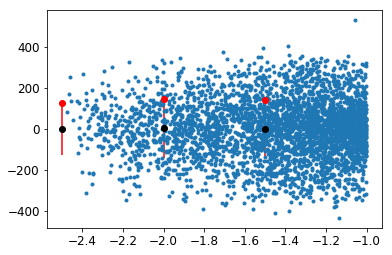

In [27]:
plt.plot(feh,vrvtvz[:,0],'.')
for i in range(0,3):
    min_feh,max_feh = i*0.5-2.5,(i+1)*0.5-2.5
    ind = (feh>min_feh) & (feh<max_feh)
    plt.plot([min_feh],[np.mean(vrvtvz[ind,0])],'ko')
    plt.plot([min_feh],[np.std(vrvtvz[ind,0])],'ro')
    plt.errorbar([min_feh],[np.mean(vrvtvz[ind,0])],yerr=np.std(vrvtvz[ind,0]),color="red")
    print(i,np.mean(vrvtvz[ind,0]),np.std(vrvtvz[ind,0]))
    

Text(0,0.5,'$V_T$')

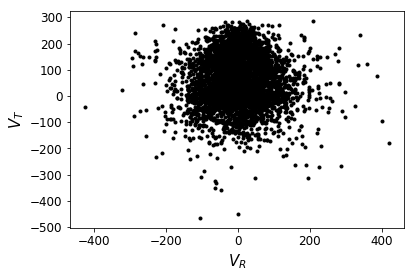

In [28]:
plt.plot(vrvtvz[:,2],vrvtvz[:,1],'k.')
plt.xlabel("$V_R$",fontsize=15)
plt.ylabel("$V_T$",fontsize=15)

array([127.07280541,  -0.9228212 ,  99.41969533])

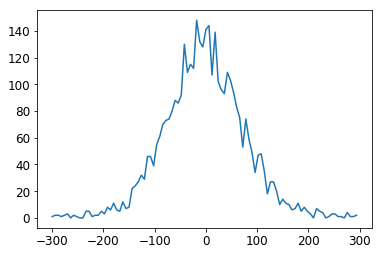

In [29]:
hyz,hxz = np.histogram(vrvtvz[:,2],bins=bins_vt)
plt.plot(hxz[:-1],hyz)
poptz

# plot results from MC with PM RV Dist convolved with error

31.388304214 1.783096562117389
[29.61157212 31.417098   33.16634036]


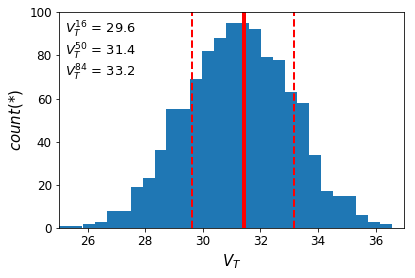

In [56]:
rcd1 = np.loadtxt(dpath+'rcd_mc1.dat')
rcd2 = np.loadtxt(dpath+'rcd_mc2.dat')
rcd3 = np.loadtxt(dpath+'rcd_mc3.dat')
rcd4 = np.loadtxt(dpath+'rcd_mc4.dat')
rcd5 = np.loadtxt(dpath+'rcd_mc5.dat')
rcd_all = np.zeros((1000,8))
rcd_all[:200,:] = rcd1
rcd_all[200:400,:] = rcd2
rcd_all[400:600,:] = rcd3
rcd_all[600:800,:] = rcd4
rcd_all[800:1000,:] = rcd5
bins_sv = np.linspace(25,37,30)
hys,hxs = np.histogram(rcd_all[:,2],bins=bins_sv)
pers = np.percentile(rcd_all[:,2],(16,50,84))
vt16 = round(pers[0],1)
vt50 = round(pers[1],1)
vt84 = round(pers[2],1)
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.15,0.2,0.8,0.75])
ax.bar(hxs[:-1],hys)
ax.plot([pers[1],pers[1]],[0,100],'r-',linewidth=4)
ax.plot([pers[0],pers[0]],[0,100],'r--',linewidth=2)
ax.plot([pers[2],pers[2]],[0,100],'r--',linewidth=2)
ax.text(25.2,90,"$V_T^{16}$ = "+"{vt16}".format(**locals()),fontsize=13)
ax.text(25.2,80,"$V_T^{50}$ = "+"{vt50}".format(**locals()),fontsize=13)
ax.text(25.2,70,"$V_T^{84}$ = "+"{vt84}".format(**locals()),fontsize=13)
ax.set_xlabel("$V_T$",fontsize=15)
ax.set_ylabel("$count(*)$",fontsize=15)
ax.set_xlim((25,37))
ax.set_ylim((0,100))
fig.savefig(ppath+"MC_VT_Err.pdf")
print(np.mean(rcd_all[:,2]),np.std(rcd_all[:,2]))
print(np.percentile(rcd_all[:,2],(16,50,84)))

In [54]:
print(vt16)

29.6


# do mcmc

In [ ]:
# import numpy as np
# #import scipy.linalg as splin
# import numpy.linalg as nl
# import matplotlib.pyplot as plt
# import matplotlib
# from matplotlib import cm
# from matplotlib.colors import Normalize
# from scipy.optimize import curve_fit
# import scipy.stats as stats
# import scipy.special as special
# import astropy.io.fits as fits
# import emcee
# import corner

# def lnprob_gauss2(x,y):
#     #n = np.float(len(y))
#     f1 = x[0]
#     mu1 = x[1]
#     sig1 = x[2]
#     mu2 = x[3]
#     sig2 = x[4]
#     f3 = x[5]
#     mu3 = x[6]
#     sig3 = x[7]
#     if np.isinf(f1) or np.isinf(mu1) or np.isinf(sig1) or\
#                np.isinf(mu2) or np.isinf(sig2) or\
#                f1<0 or f1>1 or sig1<0 or sig2<0 or\
#                (f1+f3)>1 or f3>1 or sig3<0:
# #                np.abs(mu1-14)>20 or np.abs(mu2-160)>50:
#         return -1e50
#     g1 = f1*stats.norm.pdf(y,mu1,sig1)# np.exp(-(y-mu1)**2/(2*sig1**2))/(np.sqrt(2*np.pi)*sig1)
#     g2 = (1-f1-f3)*stats.norm.pdf(y,mu2,sig2)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
#     g3 = f3*stats.norm.pdf(y,mu3,sig3)
#     g = g1+g2+g3
#     #print g
#     ind_g = (np.isinf(g)==False) & (np.isnan(g)==False) & (g>0)
#     return np.sum(np.log(g[ind_g]))

# def gauss2_model(y,p0,N, nwalkers):
#     # MCMC sampling
#     #n = len(y)
    
#     #start to configure emcee
#     #nwalkers = 40
#     #ndim = 5
#     #p0=np.zeros((nwalkers,ndim))
#     #p0[:,0] = np.random.rand(nwalkers)*0.2+0.7
#     #p0[:,1] = np.random.rand(nwalkers)*50-25
#     #p0[:,2] = np.random.rand(nwalkers)*40+20
#     #p0[:,3] = np.random.rand(nwalkers)*50-25
#     #p0[:,4] = np.random.rand(nwalkers)*5
#     ndim = p0.shape[1]
      
#     sampler = emcee.EnsembleSampler(nwalkers, \
#             ndim, lnprob_gauss2, args=[y])
#     N_burn_in = 500
    
#     pos, prob, state = sampler.run_mcmc(p0, N_burn_in)
#     sampler.reset()
    
#     sampler.run_mcmc(pos, N)
    
#     samples = sampler.chain[:, N_burn_in:, :].reshape((-1, ndim))
#     #corner.corner(samples)
#     popt = np.median(samples, axis=0)
#     pcov = np.zeros((ndim,ndim))
#     for i in range(ndim):
#         for j in range(ndim):
#             pcov[i,j] = (np.sum((samples[:,i]-popt[i])*\
#                 (samples[:,j]-popt[j])))/len(samples)
#     return popt, pcov, samples

# import time

# VT1 = vrvtvz[:,1]*1.
# nwalkers = 40
# ndim = 8
# p0=np.zeros((nwalkers,ndim))
# p0[:,0] = np.random.rand(nwalkers)                   # f1
# p0[:,1] = np.random.rand(nwalkers)*20+4              # mu1
# p0[:,2] = np.random.rand(nwalkers)*20+60             # sig1
# p0[:,3] = np.random.rand(nwalkers)*40+140            # mu2
# p0[:,4] = np.random.rand(nwalkers)*40+40             # sig2
# p0[:,5] = np.random.rand(nwalkers)*0.2            # f3
# p0[:,6] = np.random.rand(nwalkers)*40+40             # mu3
# p0[:,7] = np.random.rand(nwalkers)*40+40             # sig3
# start = time.time()
# Mpopt,Mpcov, samples = gauss2_model(VT1, p0, 1000, nwalkers)
# print(time.time()-start)
# print(Mpopt)

# do bootstrap without feh

In [ ]:
# NBST = 2000
# N_sel = int(round(len(feh)/1.5))
# rcd_allb = np.zeros((NBST,4))
# bin_vtt = np.linspace(-300,300,61)
# for i in range(0,NBST):
#     vt_tmp = vrvtvz[:,1]*1.0
#     np.random.shuffle(vt_tmp)
#     hybs,hxbs = np.histogram(vt_tmp[:N_sel],bins= bin_vtt)
#     bspopt,bs_pcov = SO.curve_fit(Gaussian2,hxbs[:-1],hybs,bounds=([50,-50,0,10,-300,0],\
#                     [1000,50,600,1000,300,600]))
    
#     rcd_allb[i,0] = bspopt[1]
#     rcd_allb[i,1] = bspopt[4]
#     rcd_allb[i,2] = bspopt[2]/np.sqrt(2)
#     rcd_allb[i,3] = bspopt[5]/np.sqrt(2)
#     if bspopt[1]>20:
#         plt.plot(hxbs[:-1],hybs,'k-')
#         plt.plot(bst,Gaussian2(bst,*bspopt),"r--")
#         mm = round(bspopt[1],2)
#         dd = round(bspopt[2]/np.sqrt(2),2)
#         plt.text(-300,100,"mean value: {mm}".format(**locals()))
#         plt.text(-300,70,"dispersion: {dd}".format(**locals()))
#         plt.show()
    
# fig = plt.figure(figsize=(6,4))
# ax = fig.add_axes([0.15,0.15,0.8,0.8])
# bin_abx = np.linspace(-50,200,251)
# bin_aby = np.linspace(-50,200,251)

# plt.plot(rcd_allb[:,2],rcd_allb[:,0],'b.')
# plt.plot(rcd_allb[:,3],rcd_allb[:,1],'g.')

# bst = np.linspace(-300,300,100001)
# plt.show()
# plt.plot(hxbs[:-1],hybs,'k-')
# plt.plot(bst,Gaussian2(bst,*bspopt),"r--")

# print(np.mean(rcd_allb[:,0]),np.std(rcd_allb[:,0]))
# print(np.mean(rcd_allb[:,1]),np.std(rcd_allb[:,1]))

# do bootstrap with feh

In [ ]:
# # plt.plot(vrvtvz[:,1],feh,'k.',alpha=0.02)
# print(bins_feh)

# fig = plt.figure(figsize=(6,4))
# ax = fig.add_axes([0.15,0.15,0.8,0.8])
# ind_vs = vrvtvz[:,1]<0
# hy_fehh,hx_fehh = np.histogram(feh[ind_vs],bins=bins_feh)
# hy_feh,hx_feh = np.histogram(feh,bins=bins_feh)
# plt.plot(hx_feh[:-1],hy_feh,'k--',label="all",linewidth=4)
# plt.plot(hx_fehh[:-1],hy_fehh,'r--',label="retrograde",linewidth=4)
# poptf,pcovf = SO.curve_fit(Gaussian,hx_fehh[:-1],hy_fehh*1.0,bounds=([10,-2,0],\
#                     [1000,0,5]))
# resp_n = Gaussian(hx_fehh,*poptf)*1.5
# for i in range(0,len(resp_n)):
#     resp_n[i] = round(resp_n[i])
# Ntt = int(np.sum(resp_n))
# print(poptf,"   hist_feh")
# xxxx = np.linspace(-2.5,0,10001)
# ax.plot(xxxx,Gaussian(xxxx,*poptf)*1.5,'b--',label="fitted",linewidth=4)
# ax.plot([poptf[1],poptf[1]],[0,1200],'b--',linewidth=2)
# ax.plot(hx_fehh,resp_n,'ko',markersize=11)
# ax.set_xlim([-2.5,-1])
# ax.set_ylim([0,1200])
# ax.set_xlabel("$[Fe/H]$",fontsize=13)
# ax.set_ylabel("$count(*)$",fontsize=13)
# ax.legend(loc=2,fontsize=14)
# plt.savefig(ppath+fn_tag+"Hist_simu_FeH.eps")

# print(Ntt)

# print(resp_n)
# print('--------------------')
# print(hy_fehh)
# N_simu = 2000
# mean_fvt = np.zeros((N_simu,2))
# disp_fvt = np.zeros((N_simu,2))
# # mean_fvt = np.zeros((N_simu,2))
# # mean_fvt = np.zeros((N_simu,2))
# plot_ind25 = 0
# plot_ind30 = 0
# plot_ind50 = 0
# plot_ind80 = 0
# plot_ind150 = 0
# for i in range(0,N_simu):
#     simu_vt = np.zeros((Ntt))-99999
#     indx = 0
#     for j in range(0,len(bins_feh)-1):
#         ind_s = (feh>bins_feh[j]) & (feh<bins_feh[j+1])
#         if len(feh[ind_s])>=resp_n[j]:
#             vt_tmp = vrvtvz[ind_s,1]
# #             print(len(vt_tmp),len(feh[ind_s]),resp_n[j])
#             np.random.shuffle(vt_tmp)
# #             if j<2:
# #                 addn = np.min([int(resp_n[j]),len(vt_tmp)])
# #             simu_vt[indx:indx+addn] = vt_tmp[:addn]
# #             print("***********",indx,indx+int(resp_n[j]),int(resp_n[j]))
#             simu_vt[indx:indx+int(resp_n[j])] = vt_tmp[:int(resp_n[j])]
#             indx = indx+int(resp_n[j])
# #         else:
# #             print(j, "not enough stars", resp_n[j])
            
#     hy_tmp,hx_tmp = np.histogram(simu_vt[simu_vt>-10000],bins= bins_vt)
#     popt_tmp,pcov_tmp = SO.curve_fit(Gaussian2,hx_tmp[:-1],hy_tmp*1.0,bounds=([50,-50,0,10,-300,0],\
#                     [1000,50,600,1000,300,600]))
    
#     m1 = popt_tmp[1]
#     m2 = popt_tmp[4]
#     s1 = popt_tmp[2]/np.sqrt(2)
#     s2 = popt_tmp[5]/np.sqrt(2)
    
#     mean_fvt[i,0] = m1#(s1 > s2 and m1) or m2
#     mean_fvt[i,1] = m2#(s1 > s2 and m2) or m1
#     disp_fvt[i,0] = s1#(s1 > s2 and s1) or s2
#     disp_fvt[i,1] = s2#(s1 > s2 and s2) or s1
#     if (np.min([s1,s2])<30) & (plot_ind30<1):
#         fig = plt.figure(figsize=(6,4))
#         ax = fig.add_axes([0.15,0.15,0.8,0.8])
#         plt.plot(hx_tmp[:-1],hy_tmp,'k-')
#         xxx = np.linspace(-300,300,10001)
#         plt.plot(xxx,Gaussian2(xxx,*popt_tmp),'r--',linewidth=4)
#         plt.plot(xxx,Gaussian(xxx,*popt_tmp[:3]),'b--',linewidth=2)
#         plt.plot(xxx,Gaussian(xxx,*popt_tmp[3:]),'g--',linewidth=2)
#         plt.plot([popt_tmp[1],popt_tmp[1]],[0,1000],'b--',linewidth=2)
#         plt.plot([popt_tmp[4],popt_tmp[4]],[0,1000],'g--',linewidth=2)
# #         plt.text(-280,80,"small dispertion")
#         plt.axis([-300,300,0,100])
#         ax.set_xlabel("$V_T$",fontsize=13)
#         ax.set_ylabel("$count(*)$",fontsize=13)
#         plt.savefig(ppath+fn_tag+"Hist_simu_VT_small.eps")
#         plt.show()
#         plot_ind30  = plot_ind30+1
#         print(plot_ind30)
        
#     if (np.min([s1,s2])<60) & (np.min([s1,s2])>50) & (plot_ind50<1):
#         fig = plt.figure(figsize=(6,4))
#         ax = fig.add_axes([0.15,0.15,0.8,0.8])
#         plt.plot(hx_tmp[:-1],hy_tmp,'k-')
#         xxx = np.linspace(-300,300,10001)
#         plt.plot(xxx,Gaussian2(xxx,*popt_tmp),'r--',linewidth=4)
#         plt.plot(xxx,Gaussian(xxx,*popt_tmp[:3]),'b--',linewidth=2)
#         plt.plot(xxx,Gaussian(xxx,*popt_tmp[3:]),'g--',linewidth=2)
#         plt.plot([popt_tmp[1],popt_tmp[1]],[0,1000],'b--',linewidth=2)
#         plt.plot([popt_tmp[4],popt_tmp[4]],[0,1000],'g--',linewidth=2)
# #         plt.text(-280,80,"normal dispertion")
#         plt.axis([-300,300,0,100])
#         ax.set_xlabel("$V_T$",fontsize=13)
#         ax.set_ylabel("$count(*)$",fontsize=13)
#         plt.savefig(ppath+fn_tag+"Hist_simu_VT_normal.eps")
#         plt.show()
#         plot_ind50 = plot_ind50+1
        
#     if (np.min([s1,s2])<30) & (plot_ind30<1):
#         fig = plt.figure(figsize=(6,4))
#         ax = fig.add_axes([0.15,0.15,0.8,0.8])
#         plt.plot(hx_tmp[:-1],hy_tmp,'k-')
#         xxx = np.linspace(-300,300,10001)
#         plt.plot(xxx,Gaussian2(xxx,*popt_tmp),'r--',linewidth=4)
#         plt.plot(xxx,Gaussian(xxx,*popt_tmp[:3]),'b--',linewidth=2)
#         plt.plot(xxx,Gaussian(xxx,*popt_tmp[3:]),'g--',linewidth=2)
#         plt.plot([popt_tmp[1],popt_tmp[1]],[0,1000],'b--',linewidth=2)
#         plt.plot([popt_tmp[4],popt_tmp[4]],[0,1000],'g--',linewidth=2)
# #         plt.text(-280,80,"small dispertion")
#         plt.axis([-300,300,0,100])
#         ax.set_xlabel("$V_T$",fontsize=13)
#         ax.set_ylabel("$count(*)$",fontsize=13)
#         plt.savefig(ppath+fn_tag+"Hist_simu_VT_smallD.eps")
#         plt.show()
#         plot_ind30  = plot_ind30+1
#         print(plot_ind30)
        
#     if (np.min([s1,s2])<100) & (np.min([s1,s2])>80) & (plot_ind80<1):
#         fig = plt.figure(figsize=(6,4))
#         ax = fig.add_axes([0.15,0.15,0.8,0.8])
#         plt.plot(hx_tmp[:-1],hy_tmp,'k-')
#         xxx = np.linspace(-300,300,10001)
#         plt.plot(xxx,Gaussian2(xxx,*popt_tmp),'r--',linewidth=4)
#         plt.plot(xxx,Gaussian(xxx,*popt_tmp[:3]),'b--',linewidth=2)
#         plt.plot(xxx,Gaussian(xxx,*popt_tmp[3:]),'g--',linewidth=2)
#         plt.plot([popt_tmp[1],popt_tmp[1]],[0,1000],'b--',linewidth=2)
#         plt.plot([popt_tmp[4],popt_tmp[4]],[0,1000],'g--',linewidth=2)
# #         plt.text(-280,80,"close dispertionss")
#         plt.axis([-300,300,0,100])
#         ax.set_xlabel("$V_T$",fontsize=13)
#         ax.set_ylabel("$count(*)$",fontsize=13)
#         plt.savefig(ppath+fn_tag+"Hist_simu_VT_closeD.eps")
#         plt.show()
#         plot_ind80 = plot_ind80+1
#     if (np.max([s1,s2])<160) & (np.max([s1,s2])>150) & (plot_ind150<1):
#         fig = plt.figure(figsize=(6,4))
#         ax = fig.add_axes([0.15,0.15,0.8,0.8])
#         plt.plot(hx_tmp[:-1],hy_tmp,'k-')
#         xxx = np.linspace(-300,300,10001)
#         plt.plot(xxx,Gaussian2(xxx,*popt_tmp),'r--',linewidth=4)
#         plt.plot(xxx,Gaussian(xxx,*popt_tmp[:3]),'b--',linewidth=2)
#         plt.plot(xxx,Gaussian(xxx,*popt_tmp[3:]),'g--',linewidth=2)
#         plt.plot([popt_tmp[1],popt_tmp[1]],[0,1000],'b--',linewidth=2)
#         plt.plot([popt_tmp[4],popt_tmp[4]],[0,1000],'g--',linewidth=2)
# #         plt.text(-280,80,"large dispertionss")
#         plt.axis([-300,300,0,100])
#         ax.set_xlabel("$V_T$",fontsize=13)
#         ax.set_ylabel("$count(*)$",fontsize=13)
#         plt.savefig(ppath+fn_tag+"Hist_simu_VT_largeD.eps")
#         plt.show()
#         plot_ind150 = plot_ind150+1
    
#     if (m1>25) & (plot_ind25<1):
#         fig = plt.figure(figsize=(6,4))
#         ax = fig.add_axes([0.15,0.15,0.8,0.8])
#         plt.plot(hx_tmp[:-1],hy_tmp,'k-')
#         xxx = np.linspace(-300,300,10001)
#         plt.plot(xxx,Gaussian2(xxx,*popt_tmp),'r--',linewidth=4)
#         plt.plot(xxx,Gaussian(xxx,*popt_tmp[:3]),'b--',linewidth=2)
#         plt.plot(xxx,Gaussian(xxx,*popt_tmp[3:]),'g--',linewidth=2)
#         plt.plot([popt_tmp[1],popt_tmp[1]],[0,1000],'b--',linewidth=2)
#         plt.plot([popt_tmp[4],popt_tmp[4]],[0,1000],'g--',linewidth=2)
# #         plt.text(-280,80,"large dispertionss")
#         plt.axis([-300,300,0,100])
#         ax.set_xlabel("$V_T$",fontsize=13)
#         ax.set_ylabel("$count(*)$",fontsize=13)
#         plt.savefig(ppath+fn_tag+"Hist_simu_VT_largeD25.eps")
#         plt.show()
#         plot_ind25 = plot_ind25+1
        
# #     print("--------------------- The {i} th simulation -------------------".format(**locals()))
# #     print(popt_tmp)
# fig_all = plt.figure(figsize=(6,4))
# ax = fig_all.add_axes([0.15,0.15,0.8,0.8])
# ax_zoom = fig_all.add_axes([0.23,0.3,0.3,0.4])
# ax.plot(disp_fvt[:,0],mean_fvt[:,0],'bo',label="halo component",alpha=1)
# ax.plot(disp_fvt[:,1],mean_fvt[:,1],'go',label="disc component",alpha=1)
# ax.plot([np.mean(disp_fvt[:,1])],[np.mean(mean_fvt[:,1])],"yo",markersize=7)
# ax_zoom.plot(disp_fvt[:,0],mean_fvt[:,0],'bo',label="halo component",alpha=1)
# mean_mean_vt = np.mean(mean_fvt[:,0])
# mean_disp_vt = np.mean(disp_fvt[:,0])
# r_vt = round(mean_mean_vt,1)
# r_disp = round(mean_disp_vt,1)
# d_vt = round(np.std(mean_fvt[:,0]),1)
# d_disp = round(np.std(disp_fvt[:,0]),1)
# ax_zoom.plot([mean_disp_vt],[mean_mean_vt],"ro",markersize=7)
# ax_zoom.set_xlim([mean_disp_vt-10,mean_disp_vt+10])
# ax_zoom.set_ylim([mean_mean_vt-10,mean_mean_vt+10])
# ax.legend()
# ax.set_xlabel("$\sigma$",fontsize=15)
# ax.set_ylabel("$<V_T>$",fontsize=15)
# ax_zoom.grid()
# ax.text(63,100,"$<<V_T>>$ = {r_vt}$\pm${d_vt}".format(**locals()),color='r',fontsize=12)
# ax.text(63,70,"$<\sigma>$ = {r_disp}$\pm${d_disp}".format(**locals()),color='r',fontsize=12)   

# ax_zoom.plot([mean_disp_vt,mean_disp_vt],[-500,300],'k--',linewidth=3)
# ax_zoom.plot([-200,200],[mean_mean_vt,mean_mean_vt],'k--',linewidth=3)
# # plt.show(fig_all)
# # plt.axis([50,80,165,175])
# plt.savefig(ppath+fn_tag+"VT_distribution.eps")
# print("mean and disp of disc component",np.mean(disp_fvt[:,1]),np.mean(mean_fvt[:,1]))

In [ ]:
# print([np.mean(disp_fvt[:,1])],[np.mean(mean_fvt[:,1])])
# print([np.std(disp_fvt[:,1])],[np.std(mean_fvt[:,1])])

In [ ]:
# fig = plt.figure(figsize=(6,4))
# plt.plot(mean_fvt[:,0],mean_fvt[:,1],'ko')
# plt.xlabel("$<V_T^{halo}>$",fontsize=13)
# plt.ylabel("$<V_T^{disc}>$",fontsize=13)
# plt.savefig(ppath+fn_tag+"DD_halodisc.eps")

In [ ]:

# print("mean and disp of disc component",np.mean(disp_fvt[:,1]),np.mean(mean_fvt[:,1]),np.std(disp_fvt[:,1]),np.std(mean_fvt[:,1]))
# plt.plot(disp_fvt[:,0],disp_fvt[:,1],'k.',alpha=0.1)
# plt.show()
# ind_ms100 = mean_fvt[:,1]>100
# ind_ms = mean_fvt[:,1]<10000
# plt.plot(mean_fvt[ind_ms,0],mean_fvt[ind_ms,1],'k.',alpha=0.1)
# plt.plot(mean_fvt[ind_ms100,1],mean_fvt[ind_ms100,0],'r.')
# print(np.mean(mean_fvt[ind_ms,0]),np.mean(mean_fvt[ind_ms,1]))
# print(np.std(mean_fvt[ind_ms,0]),np.std(mean_fvt[ind_ms,1]))

In [ ]:
# feh_edge = np.linspace(-2.5,-1.1,8)
# mean_fvt0 = np.zeros((7,2))
# disp_fvt0 = np.zeros((7,2))
# bins_vt0 = np.linspace(-300,300,41)
# for i in range(0,7):
#     limit_feh0 = round(feh_edge[i],1)
#     limit_feh1 = round(feh_edge[i+1],1)
#     ind_sfeh =  (feh>feh_edge[i]) & (feh<feh_edge[i+1])
#     hysv,hxsv = np.histogram(vrvtvz[ind_sfeh,1],bins=bins_vt0)
#     fig = plt.figure(figsize=(6,4))
#     plt.plot(hxsv[:-1]+0.5*(hxsv[1]-hxsv[0]),hysv/np.sum(hysv),'k--',linewidth = 5)
#     poptsv,pcovsv = SO.curve_fit(Gaussian2,hxsv[:-1]+0.5*(hxsv[1]-hxsv[0]),hysv*1.0/np.sum(hysv),\
#                                  bounds=([0.05,-50,0,0.,100,0],[1,50,600,1,300,600]))
    
#     poptsv1,pcovsv1 = SO.curve_fit(Gaussian,hxsv[:-1]+0.5*(hxsv[1]-hxsv[0]),hysv*1.0/np.sum(hysv),\
#                                    bounds=([0.05,-30,0],[1,100,600]))
#     xxxx = np.linspace(-300,300,10001)
#     m1 = poptsv[1]
#     m2 = poptsv[4]
#     s1 = poptsv[2]
#     s2 = poptsv[5]
#     Nb = len(vrvtvz[ind_sfeh,1])
# #     mean_fvt0[i,0] = (s1 > s2 and m1) or m2
# #     mean_fvt0[i,1] = (s1 > s2 and m2) or m1
# #     disp_fvt0[i,0] = (s1 > s2 and s1) or s2
# #     disp_fvt0[i,1] = (s1 > s2 and s2) or s1
    
#     mean_fvt0[i,0] = m1
#     mean_fvt0[i,1] = m2
#     disp_fvt0[i,0] = s1
#     disp_fvt0[i,1] = s2
#     plt.plot(xxxx,Gaussian2(xxxx,*poptsv),'r--',linewidth=4)
#     plt.plot(xxxx,Gaussian(xxxx,*poptsv1),'c--',linewidth=4)
#     plt.plot(xxxx,Gaussian(xxxx,*poptsv[:3]),'b--',linewidth=2)
#     plt.plot(xxxx,Gaussian(xxxx,*poptsv[3:]),'g--',linewidth=2)
#     plt.plot([m1,m1],[0,1],'b--')
#     plt.plot([m2,m2],[0,1],'g--')
# #     if s1>s2 :
# #         plt.plot(xxxx,Gaussian(xxxx,*poptsv[:3]),'b--',linewidth=2)
# #         plt.plot(xxxx,Gaussian(xxxx,*poptsv[3:]),'g--',linewidth=2)
# #         plt.plot([m1,m1],[0,1],'b--')
# #         plt.plot([m2,m2],[0,1],'g--')
# #     else:
# #         plt.plot(xxxx,Gaussian(xxxx,*poptsv[:3]),'g--',linewidth=2)
# #         plt.plot(xxxx,Gaussian(xxxx,*poptsv[3:]),'b--',linewidth=2)
# #         plt.plot([m1,m1],[0,1],'g--')
# #         plt.plot([m2,m2],[0,1],'b--')
#     plt.axis([-300,300,0,0.1])
#     plt.text(-280,0.06,"$N$ = {Nb}".format(**locals()),fontsize=13)
#     plt.text(-280,0.09,"{limit_feh0} < $[Fe/H]$ < {limit_feh1}".format(**locals()),fontsize=13)
#     mm1 = round(m1,1)
#     mm2 = round(m2,1)
#     plt.text(-280,0.08,"$<V_T>^{halo}$ = "+"{mm1}".format(**locals()),fontsize=13,color='r')
#     plt.text(-280,0.07,"$<V_T>^{disc}$ = "+"{mm2}".format(**locals()),fontsize=13,color='g')
#     mm3 = round(poptsv1[1],1)
#     plt.ylabel("$count(*)$",fontsize=15)
#     plt.xlabel("$<V_T>$",fontsize=15)
#     print(poptsv1[1])
#     plt.text(100,0.08,"$<V_T>$ = "+"{mm3}".format(**locals()),fontsize=13,color='c')
#     plt.savefig(ppath+fn_tag+"VT_FEH_{i}.eps".format(**locals()))
#     plt.show()
    
#     print("diag of Gaussian2",np.sqrt(np.diag(pcovsv)))
#     print("diag of Gaussian1",np.sqrt(np.diag(pcovsv1)))
# plt.plot(feh_edge[:-1],mean_fvt0[:,0],'b-',linewidth=3,label="halo")
# plt.plot(feh_edge[:-1],mean_fvt0[:,1],'g-',linewidth=3,label="disc")
# plt.plot(feh_edge[:-1],disp_fvt0[:,0],'b--',linewidth=3)
# plt.plot(feh_edge[:-1],disp_fvt0[:,1],'g--',linewidth=3)
# plt.plot([-2.5,0],[mean_mean_vt,mean_mean_vt],'r--',label='<$V_T$>')
# plt.xlabel("$[Fe/H]$",fontsize=15)
# plt.ylabel("$<V_T>$",fontsize=15)
# plt.axis([-2.6,-1.2,0,300])
# plt.legend()
# plt.savefig(ppath+fn_tag+"VT_FEH_all.eps")

In [ ]:
# resp_n = Gaussian(hx_fehh[:-1],*poptf)*2
# Nresp = np.array([int(round(nnn)) for nnn in resp_n])
# print(Nresp)
# # res_vt0 =  resp_n-hy_fehh
# N_t = np.sum(resp_n)
# SVT = np.zeros(int(N_t))-9999
# N_r = 10
# meanVT = np.zeros((N_r,2))
# print(bins_feh,len(bins_feh))
# for i in range(0,N_r):
#     n_ind = 0
#     for j in range(1,len(bins_feh)-1):
#         inds = (feh>=bins_feh[j]) & (feh<bins_feh[j+1])
# #         inds = (vrvtvz[:,1]>0) & (feh>=bins_feh[j]) & (feh<bins_feh[j+1])
#         n_with = len(feh[inds])
#         vt_tmp = vrvtvz[inds,1]
#         np.random.shuffle(vt_tmp)
#         n_indend = int(round(n_ind+resp_n[j]))
#         SVT[n_ind:n_indend] = vt_tmp[:int(round(resp_n[j]))]
#         n_ind = n_indend
        
#     ind_m0 = (feh>=bins_feh[1]) & (feh<-1)
# #     ind_m0 = (vrvtvz[:,1]<0) & (feh>=bins_feh[1]) & (feh<-1)
#     print(np.sum(hy_fehh[1:]),len(feh[ind_m0]))
# #     SVT[n_ind:np.sum(hy_fehh[1:])+n_ind] = vrvtvz[ind_m0,1]
#     hy_svt,hx_svt = np.histogram(SVT,bins = bins_vt)
#     plt.plot(hx_svt[:-1],hy_svt)
#     plt.show()
# #         if res_vt0[j]>n_with:
# #             print("error with fewer stars in this bin",j,bins_feh[j],bins_feh[j+1],res_vt0[j],n_with)
# #         else:
# #             print(i,'-----',j)

In [ ]:
# hy_svt,hx_svt = np.histogram(SVT,bins = bins_vt)
# plt.plot(hx_svt[:-1],hy_svt)
# print(len(SVT[SVT>-1000]))
# print(len(SVT[SVT<0]))

In [ ]:
# indsv = vxvyvz[:,1]<-256
# fig = plt.figure(figsize=(5,4))
# ax = fig.add_axes([0.12,0.15,0.83,0.85])
# plt.plot(xyz[:,0],xyz[:,1],'k.',alpha=1)
# plt.xlabel("X",fontsize=15)
# plt.ylabel("Y",fontsize=15)
# plt.savefig(ppath+fn_tag+"XY.eps")
# plt.show()
# fig = plt.figure(figsize=(5,4))
# ax = fig.add_axes([0.12,0.15,0.83,0.85])
# plt.plot(xyz[:,0],xyz[:,2],'k.',alpha=1)
# plt.xlabel("X",fontsize=15)
# plt.ylabel("Z",fontsize=15)
# plt.savefig(ppath+fn_tag+"XZ.eps")
# plt.show()
# bin_feh = np.linspace(-2.5,-1,16)
# hy,hx = np.histogram(feh,bins=bin_feh)
# plt.plot(hx[:-1],hy,'ko-')
# # plt.plot(xyz[indsv,0],xyz[indsv,2],'r.',alpha=0.1)

In [ ]:
# bins_xyz = np.linspace(-4,4,41)
# Hxy,xed,yed = np.histogram2d(xyz[:,0],xyz[:,1],bins=(bins_xyz,bins_xyz))
# Hxz,xed,yed = np.histogram2d(xyz[:,0],xyz[:,2],bins=(bins_xyz,bins_xyz))

# plt.contourf(xed[:-1],yed[:-1],np.log10(Hxz.T+1),levels=np.linspace(0,2.,51),cmap = "gist_rainbow")
# plt.colorbar()
# plt.xlabel("X")
# plt.ylabel("Z")
# plt.show()
# plt.contourf(xed[:-1],yed[:-1],np.log10(Hxy.T+1),levels=np.linspace(0,2.,51),cmap = "gist_rainbow")
# plt.colorbar()
# plt.xlabel("X")
# plt.ylabel("Y")


In [ ]:
Lx = (xyz[:,1])*(vxvyvz[:,2]+W_sun) - xyz[:,2]*(vxvyvz[:,1]+V_LSR+V_sun)
Ly = (xyz[:,2])*(vxvyvz[:,0]+U_sun)*(-1) - (X_sun-xyz[:,0])*(vxvyvz[:,2]+W_sun)
Lz = (X_sun-xyz[:,0])*(vxvyvz[:,1]+V_LSR+V_sun) - xyz[:,1]*(vxvyvz[:,0]+U_sun)*(-1)  # convert to GSR U
Lxy = np.sqrt(Lx**2+Ly**2)
bins_L = np.linspace(-3000,3000,151)
print('----------------------')
hyL,hxL = np.histogram(Lx,bins=bins_L)
plt.plot(hxL[:-1],hyL,'k-')
poptL,pcovL = SO.curve_fit(Gaussian,hxL[:-1],hyL*1.0,bounds=([10,-2000,0],\
                    [2000,2000,10000]))
plt.plot(xxxxL,Gaussian(xxxxL,*poptL),'r--',linewidth=5)
# poptL,pcovL = SO.curve_fit(Gaussian2,hxL[:-1],hyL*1.0,bounds=([10,-2000,0,10,-2000,0],\
#                     [2000,2000,10000,2000,2000,10000]))
# xxxxL = np.linspace(-10000,10000,1000001)
# plt.plot(xxxxL,Gaussian2(xxxxL,*poptL),'r--',linewidth=5)
# plt.plot(xxxxL,Gaussian(xxxxL,*poptL[:3]),'g--',linewidth=3)
# plt.plot(xxxxL,Gaussian(xxxxL,*poptL[3:]),'b--',linewidth=3)
# plt.plot([poptL[1],poptL[1]],[0,200],'b--',linewidth=3)
plt.axis([-3000,3000,0,750])
plt.xlabel("$L_X$",fontsize=20)
plt.ylabel("$count(*)$",fontsize=20)
plt.show()
print(poptL)
print(np.sqrt(np.diag(pcovL)))
print(np.max(np.abs(Lz/R-vrvtvz[:,1])))
print('----------------------')
bins_L = np.linspace(-3000,3000,201)
hyL,hxL = np.histogram(Ly,bins=bins_L)
plt.plot(hxL[:-1],hyL,'k-')
poptL,pcovL = SO.curve_fit(Gaussian,hxL[:-1],hyL*1.0,bounds=([10,-2000,0],\
                    [500,2000,10000]))
plt.plot(xxxxL,Gaussian(xxxxL,*poptL),'r--',linewidth=5)
# poptL,pcovL = SO.curve_fit(Gaussian2,hxL[:-1],hyL*1.0,bounds=([10,-2000,0,10,-2000,0],\
#                     [2000,2000,10000,2000,2000,10000]))
# xxxxL = np.linspace(-10000,10000,1000001)
# plt.plot(xxxxL,Gaussian2(xxxxL,*poptL),'r--',linewidth=5)
# plt.plot(xxxxL,Gaussian(xxxxL,*poptL[:3]),'g--',linewidth=3)
# plt.plot(xxxxL,Gaussian(xxxxL,*poptL[3:]),'b--',linewidth=3)
# plt.plot([poptL[1],poptL[1]],[0,200],'b--',linewidth=3)
plt.axis([-3000,3000,0,150])
plt.xlabel("$L_Y$",fontsize=20)
plt.ylabel("$count(*)$",fontsize=20)
plt.show()
print(poptL)
print(np.sqrt(np.diag(pcovL)))
print(np.max(np.abs(Lz/R-vrvtvz[:,1])))
print('----------------------')
bins_L = np.linspace(-3000,3000,201)
hyL,hxL = np.histogram(Lz,bins=bins_L)
plt.plot(hxL[:-1],hyL,'k-')
poptL,pcovL = SO.curve_fit(Gaussian2,hxL[:-1],hyL*1.0,bounds=([40,-2000,0,10,-2000,0],\
                    [2000,2000,10000,2000,2000,10000]))
xxxxL = np.linspace(-10000,10000,1000001)
plt.plot(xxxxL,Gaussian2(xxxxL,*poptL),'r--',linewidth=5)
plt.plot(xxxxL,Gaussian(xxxxL,*poptL[:3]),'g--',linewidth=3)
plt.plot(xxxxL,Gaussian(xxxxL,*poptL[3:]),'b--',linewidth=3)
# plt.plot([poptL[1],poptL[1]],[0,200],'b--',linewidth=3)
plt.axis([-3000,3000,0,80])
plt.xlabel("$L_Z$",fontsize=20)
plt.ylabel("$count(*)$",fontsize=20)
plt.show()
print(poptL)
print(np.sqrt(np.diag(pcovL)))
print(np.max(np.abs(Lz/R-vrvtvz[:,1])))


In [ ]:
plt.plot(vxvyvz[:,1],vrvtvz[:,1],'k.')


In [ ]:
Lllbb = gub.XYZ_to_lbd(Lx,Ly,Lz,degree=True)
plt.plot(Lllbb[:,0],Lllbb[:,1],'k.',alpha=0.1)
plt.show()
plt.plot(Ly,Lz,'k.')
plt.xlabel("$L_Y$",fontsize=20)
plt.ylabel("$L_Z$",fontsize=20)
plt.axis([-3000,3000,-3000,3000])
plt.show()
plt.plot(Lx,Lz,'k.')
plt.axis([-3000,3000,-3000,3000])
plt.xlabel("$L_X$",fontsize=20)
plt.ylabel("$L_Z$",fontsize=20)
plt.show()
plt.plot(Lx,Ly,'k.')
plt.axis([-3000,3000,-3000,3000])
plt.xlabel("$L_X$",fontsize=20)
plt.ylabel("$L_Y$",fontsize=20)
plt.show()
# plt.plot(Lz/R,vrvtvz[:,1],'k.')
# plt.plot([-1000,1000],[-1000,1000])
# plt.axis([-1000,1000,-1000,1000])
# plt.show()
bins_2DL = np.linspace(-3000,3000,151)
Hxy,xedge,yedge = np.histogram2d(Lx,Ly,bins=(bins_2DL,bins_2DL))
Hxz,xedge,zedge = np.histogram2d(Lx,Lz,bins=(bins_2DL,bins_2DL))
Hyz,yedge,zedge = np.histogram2d(Ly,Lz,bins=(bins_2DL,bins_2DL))
stp = (bins_2DL[1]-bins_2DL[0])*0.5
plt.contourf(xedge[:-1]+stp,yedge[:-1]+stp,np.log10(Hxy.T+1),cmap="gist_rainbow")
plt.axis([-3000,3000,-3000,3000])
plt.xlabel("$L_X$",fontsize=20)
plt.ylabel("$L_Y$",fontsize=20)
plt.show()
plt.contourf(xedge[:-1]+stp,zedge[:-1]+stp,np.log10(Hxz.T+1),cmap="gist_rainbow")
plt.axis([-3000,3000,-3000,3000])
plt.xlabel("$L_X$",fontsize=20)
plt.ylabel("$L_Z$",fontsize=20)
plt.show()
plt.contourf(yedge[:-1]+stp,zedge[:-1]+stp,np.log10(Hyz.T+1),cmap="gist_rainbow")
plt.axis([-3000,3000,-3000,3000])
plt.xlabel("$L_Y$",fontsize=20)
plt.ylabel("$L_Z$",fontsize=20)
plt.show()
plt.contourf(xedge[:-1]+stp,zedge[:-1]+stp,np.log10(Hxz.T+1),cmap="gist_rainbow")
plt.axis([-500,500,-1000,2000])
plt.xlabel("$L_X$",fontsize=20)
plt.ylabel("$L_Z$",fontsize=20)
plt.show()

In [ ]:
nside = 32

npix = hp.nside2npix(nside)

# Coordinates and the density field f
thetas = math.pi-(Lllbb[:,1]*math.pi/180+math.pi/2)
phis =Lllbb[:,0]*math.pi/180
nsources = len(Lllbb[:,1])
# ind = Lz<0
# Go from HEALPix coordinates to indices
indices = hp.ang2pix(nside, thetas, phis)
def gen_fast_map(ip_, nside=512):
    npixel  = hp.nside2npix(nside)
    map_ = np.bincount(ip_,minlength=npixel)
#     map_ = hp.reorder(map_, inp="RING", out="RING")
    return map_

map = gen_fast_map(indices,nside=nside)
from pylab import arange, show, cm
cmap = cm.gist_rainbow
# cmap = cm.binary
cmap.set_under('k')
hp.mollview(np.log10(map+1),title='$log_{10}(N+1)$',min=0,max=1.,rot=[0,90,0],cmap=cmap)
plt.savefig(ppath+"healpy.pdf")

print(np.max(Lllbb[:,1]),np.min(Lllbb[:,1]))


In [ ]:
# ## bin R and Z calculate the mean rotation velocity Vij, contour Vij and dispersion
# R = np.sqrt((X_sun-xyz[:,0])**2+xyz[:,1]**2)
# Z = xyz[:,2]
# rr = np.sqrt(R**2+Z**2)
# size_R, size_Z = 2,26
# min_R,max_R = 0,20
# min_Z,max_Z = -10,16
# nR = int((max_R-min_R)/size_R)
# nZ = int((max_Z-min_Z)/size_Z)
# mean_vt = np.zeros((nR,nZ))-999
# mean_lz = np.zeros((nR,nZ))-999
# disp_vt = np.zeros((nR,nZ))-999
# disp_lz = np.zeros((nR,nZ))-999

# mean_vtm = np.zeros((nR,nZ))-999
# mean_lzm = np.zeros((nR,nZ))-999
# disp_vtm = np.zeros((nR,nZ))-999
# disp_lzm = np.zeros((nR,nZ))-999

# nnn = np.zeros((nR,nZ))
# for i in range(0,nR):
#     S0_R, S1_R = min_R+i*size_R,min_R+i*size_R+size_R
#     for j in range(0,nZ):
#         S0_Z, S1_Z = min_Z+j*size_Z,min_Z+j*size_Z+size_Z
#         ind_S = (R>=S0_R) & (R<=S1_R) & (np.abs(Z)>3) & (feh<-1.) #& (rr>3)#(Z>=S0_Z) & (Z<=S1_Z) 
#         VT_S = vrvtvz[ind_S,1]
#         Lz_S = Lz[ind_S]
#         nnn[i,j] = len(Lz_S)
#         if nnn[i,j]>50:
#             hy,hx = np.histogram(VT_S,bins = bins_vt)
#             hyL,hxL = np.histogram(Lz_S,bins = bins_L)
#             popt,pcov = SO.curve_fit(Gaussian,hx[:-1],hy*1.0,bounds=([10,-100,0],\
#                         [200,100,10000]))
#             poptL,pcovL = SO.curve_fit(Gaussian,hxL[:-1],hyL*1.0,bounds=([10,-2000,0],\
#                         [200,2000,10000]))
# #             mean_vt[i,j], mean_lz[i,j] = popt[1], poptL[1]
# #             disp_vt[i,j], disp_lz[i,j] = popt[2], poptL[2]
#             mean_vt[i,j], mean_lz[i,j] = popt[1], poptL[1]
#             disp_vt[i,j], disp_lz[i,j] = popt[2], poptL[2]
        
#             mean_vtm[i,j], mean_lzm[i,j] = np.mean(VT_S),np.mean(Lz_S)
#             disp_vtm[i,j], disp_lzm[i,j] = np.std(VT_S),np.std(Lz_S)
            
# #             plt.plot(hx[:-1],hy,'k-')
# #             plt.show()
# #             plt.scatter(Lz[ind_S],Lxy[ind_S],c=VT_S,cmap='gist_rainbow',vmin=-400,vmax=400)
# #             plt.colorbar()
# # #             plt.axis([-500,500,0,200])
# #             plt.show()
# ind_vt = mean_vt[:,0]>-999
# plt.plot(np.linspace(min_R,max_R,nR+1)[:-1][ind_vt]+size_R*0.5,mean_vt[ind_vt,0],\
#          'bp--',label="$<V_{\phi}>$")
# plt.plot(np.linspace(min_R,max_R,nR+1)[:-1][ind_vt]+size_R*0.5,nnn[ind_vt,0],\
#          'mo--',label="$N$")
# plt.plot(np.linspace(min_R,max_R,nR+1)[:-1][ind_vt]+size_R*0.5,disp_vt[ind_vt,0],\
#          'go--',label="$\sigma_{V_{\phi}}$")
# plt.plot(np.linspace(min_R,max_R,nR+1)[:-1][ind_vt]+size_R*0.5,mean_lz[ind_vt,0]/80,\
#          'co--',label="$<L_Z>$")

# plt.plot(np.linspace(min_R,max_R,nR+1)[:-1][ind_vt]+size_R*0.5,mean_vtm[ind_vt,0],\
#          'bp-',label="$<V_{\phi}>$")
# plt.plot(np.linspace(min_R,max_R,nR+1)[:-1][ind_vt]+size_R*0.5,disp_vtm[ind_vt,0],\
#          'go-',label="$\sigma_{V_{\phi}}$")
# plt.plot(np.linspace(min_R,max_R,nR+1)[:-1][ind_vt]+size_R*0.5,mean_lzm[ind_vt,0]/80,\
#          'co-',label="$<L_Z>$")

# plt.plot([0,20],[0,0],'k--')
# plt.plot([0,20],[10,10],'k--')
# plt.axis([0,20,-80,1000])
# plt.xlabel("$R/kpc$")
# plt.ylabel("$<V_{\phi}>/km$ $s^{-1}$")
# plt.legend(loc=1)
# plt.show()
# # print(np.min(mean_lz[ind_vt,0]))
# # print(bins_L)
# plt.plot(Lz_S/R[ind_S],VT_S,'ko')
# plt.plot([-300,300],[-300,300])

In [ ]:
# drt = np.array([1,0,0.5])
# drt = drt/np.sqrt(drt[0]**2+drt[1]**2+drt[2]**2)
# print(drt)
# dst = ((X_sun-xyz[:,0])*drt[0]+xyz[:,1]*drt[1]+xyz[:,2]*drt[2])/rr
# adst = np.arccos(dst)*180/math.pi
# thd = 15  # in degree
# ind_pb = (adst<thd) & (np.abs(Z)>5)
# print(len(adst[ind_pb]))
# plt.plot(rr[ind_pb],vrvtvz[ind_pb,1],'k.',alpha = 0.1)
# plt.axis([5,22.5,-200,200])
# for i in range(0,7):
#     indsr = (rr<(i*2.5+7.5)) & (rr>((i*2.5+5))) & (adst<thd) & (np.abs(Z)>5)
#     if len(rr[indsr])>5 :
#         plt.plot([i*2.5+5+1.25],[np.mean(vrvtvz[indsr,1])],'ro')
#         plt.plot([i*2.5+5+1.25],[len(vrvtvz[indsr,1])],'bo')
#         print([np.mean(vrvtvz[indsr,1])])

In [ ]:
# print(np.max(pmra_eG*dist*4.74))
# print(np.max(dist))
# bins_ev = np.linspace(0,25,26)
# hy_ev,hx_ev = np.histogram(rvGe,bins=bins_ev)
# plt.plot(hx_ev[:-1],hy_ev,'k-')

In [ ]:
# 0.4/40/2

In [ ]:
# ind_feh = feh<-1.4
# hy_vt,hx_vt = np.histogram(vrvtvz[ind_feh,1],bins=bins_vt)
# plt.plot(hx_vt[:-1],hy_vt,'k-')
# poptL,pcovL = SO.curve_fit(Gaussian2,hx_vt[:-1],hy_vt*1.0,bounds=([10,-500,0,10,-500,0],\
#                     [200,500,10000,200,500,10000]))
# xxxxL = np.linspace(-500,500,10001)
# plt.plot(xxxxL,Gaussian(xxxxL,*poptL[:3]),'g--',linewidth=5)
# plt.plot(xxxxL,Gaussian(xxxxL,*poptL[3:]),'b--',linewidth=5)
# plt.plot(xxxxL,Gaussian2(xxxxL,*poptL),'r--',linewidth=5)
# plt.xlabel("$V_{T}$",fontsize=15)
# plt.ylabel("$count(*)$",fontsize=15)
# print(*poptL)
# print(np.sqrt(np.diag(pcovL)))

In [ ]:
# indsvt = (vrvtvz[:,1]>-55) & (vrvtvz[:,1]<-45) & (feh<-1.4) 
# print(len(vrvtvz[indsvt,1]))
# plt.scatter(X_sun-xyz[indsvt,0],xyz[indsvt,1],c=feh[indsvt],cmap='gist_rainbow',vmin=-2.5,vmax=-1)
# plt.colorbar()
# plt.quiver(X_sun-xyz[indsvt,0],xyz[indsvt,1],(vxvyvz[indsvt,0]+U_sun)*(-1),\
#            vxvyvz[indsvt,1]+V_LSR+V_sun,cmap='gist_rainbow',scale=3000)
# plt.show()

# plt.plot(Lx,Ly,'k.',alpha=0.01)
# plt.plot(Lx[indsvt],Ly[indsvt],'k.')
# plt.axis([-1000,1000,-1000,1000])
# plt.show()
# plt.plot(xyz[:,1],xyz[:,2],'k.',alpha=0.01)
# plt.plot(xyz[indsvt,1],xyz[indsvt,2],'k.')
# plt.quiver(xyz[indsvt,1],xyz[indsvt,2],vxvyvz[indsvt,1]+V_LSR+V_sun,vxvyvz[indsvt,2]+W_sun,\
#            cmap='gist_rainbow',scale=3000)
# plt.show()
# # plt.plot(feh,vrvtvz[:,1],'k.',alpha=0.01)
# plt.plot(feh[indsvt],vrvtvz[indsvt,1],'k.')
# plt.show()
# plt.plot(vrvtvz[:,0],vrvtvz[:,2],"k.",alpha=0.01)
# plt.plot(vrvtvz[indsvt,0],vrvtvz[indsvt,2],"k.")
# plt.show()
# plt.plot(vxvyvz[:,2],vxvyvz[:,1],"k.",alpha=0.01)
# plt.plot(vxvyvz[indsvt,2],vxvyvz[indsvt,1],"k.")
# plt.xlabel("VX")
# plt.ylabel("VY")

# plt.show()
# plt.plot(Lz[indsvt]/R[indsvt],vrvtvz[indsvt,1],'k.')

In [ ]:
# Lxy = np.sqrt(Lx**2+Ly**2)
# plt.plot(Lz,Lxy,'k.',alpha=0.2)
# # indr = np.sqrt(R**2+Z**2)<1
# # print(len(Z[indr]))
# # plt.plot(Lz[indr],Lxy[indr],'r.')
# Lz0, Lz1= -400,-200
# Lxy0,Lxy1 = 1700,1800
# plt.plot([Lz0,Lz1,Lz1,Lz0,Lz0],[Lxy0,Lxy0,Lxy1,Lxy1,Lxy0],'r-',linewidth=2)
# plt.xlabel("$L_Z$",fontsize=15)
# plt.ylabel("$L_{XY}$",fontsize=15)
# plt.axis([-4000,4000,0,4000])
# plt.savefig(ppath+fn_tag+"AM.pdf")
# plt.show()
# bin_lz = np.linspace(-4000,4000,81)
# bin_lzy = np.linspace(0,4000,41)
# H_L,xedgesL,yedgesL = np.histogram2d(Lz,Lxy,bins=(bin_lz,bin_lzy))
# plt.contourf(xedgesL[:-1]+(xedgesL[1]-xedgesL[0])*0.5,\
#              yedgesL[:-1]+(yedgesL[1]-yedgesL[0])*0.5,\
#              H_L.T,cmap='gist_rainbow',levels=np.linspace(0,45,201))
# plt.colorbar()
# plt.plot([Lz0,Lz1,Lz1,Lz0,Lz0],[Lxy0,Lxy0,Lxy1,Lxy1,Lxy0],'k-',linewidth=2)
# axxx = np.linspace(0,math.pi,10000)
# for i in range(1,4):
#     plt.plot(i*1000*np.cos(axxx),i*1000*np.sin(axxx),'k--',linewidth=1.5)
#     plt.plot(i*500*np.cos(axxx)+1960,i*500*np.sin(axxx),'k--',linewidth=1.5)
    
# plt.xlabel("$L_Z$",fontsize=15)
# plt.ylabel("$L_{XY}$",fontsize=15)
# plt.axis([-2000,2000,0,3000])
# plt.savefig(ppath+fn_tag+"AM_contour.pdf")
# plt.show()
# hylz,hxlz = np.histogram(Lz,bins=bin_lz)
# plt.plot(hxlz[:-1],hylz,'k--',linewidth=2)
# poptlz,pcovlz  = SO.curve_fit(Gaussian2,hxlz[:-1],hylz*1.0,bounds=([0,-1000,0,0,-1000,0],\
#                     [1000,1000,10000,1000,1000,10000]))
# xxxxLx = np.linspace(-10000,10000,1000001)
# plt.plot(xxxxLx,Gaussian2(xxxxLx,*poptlz),'r--',linewidth=1)
# plt.plot(xxxxLx,Gaussian(xxxxLx,*poptlz[:3]),'g--',linewidth=0.5)
# plt.plot(xxxxLx,Gaussian(xxxxLx,*poptlz[3:]),'b--',linewidth=0.5)
# plt.xlabel("$L_Z$",fontsize=15)
# plt.ylabel("$count(*)$",fontsize=15)
# plt.savefig(ppath+fn_tag+"hist_Lz.pdf")
# print(poptlz)

In [ ]:
# Lz0, Lz1= -300,-100#-800,-650#-600,-450#
# Lxy0,Lxy1 = 550,750#500,800#200,500#
# wvw,wv,xcent,ycent = wavetrans(Lz,Lxy,-2000,2000,0,4000,40,40,1.,1.)
# print(np.min(wvw),np.max(wvw))
# plt.contourf(xcent,ycent,(wv.T),cmap="gist_rainbow",levels=np.linspace(10,50,101))
# plt.plot([Lz0,Lz1,Lz1,Lz0,Lz0],[Lxy0,Lxy0,Lxy1,Lxy1,Lxy0],'k-',linewidth=2)
# plt.colorbar()
# plt.show()
# plt.contourf(xcent,ycent,wvw.T,cmap="gist_rainbow",\
#              levels=np.linspace(1,2000,101))
# plt.plot([Lz0,Lz1,Lz1,Lz0,Lz0],[Lxy0,Lxy0,Lxy1,Lxy1,Lxy0],'k-',linewidth=2)
# plt.colorbar()
# print(wv[10:12,10:12])
# print(wvw[10:12,10:12])
# plt.xlabel("$L_{Z}$")
# plt.ylabel("$L_{XY}$")


In [ ]:
# plt.plot(Lxy,vrvtvz[:,1],'k.',alpha=1)
# plt.axis([600,800,-100,100])

In [ ]:
# ind_s1 = (Lz>Lz0) & (Lz<Lz1) & (Lxy>Lxy0) & (Lxy<Lxy1) #& (X_sun-xyz[:,0]>8) & (X_sun-xyz[:,0]<9)#  & (feh<-1.4)
# fig = plt.figure(figsize=(10,5))
# ax1 = fig.add_axes([0.08,0.15,0.44,0.8])
# ax2 = fig.add_axes([0.52,0.15,0.44,0.8])
# axc = fig.add_axes([0.96,0.15,0.01,0.8])
# ax1.plot(vrvtvz[:,0],vrvtvz[:,2],'ko',markersize=1,alpha=0.1)
# # ax1.plot(vrvtvz[ind_s1,0],vrvtvz[ind_s1,2],'ro',markersize=5)
# ca = ax1.scatter(vrvtvz[ind_s1,0],vrvtvz[ind_s1,2],c=feh[ind_s1],\
#                  s=200,cmap="gist_rainbow",vmin=-2.5,vmax=-1)
# ax2.plot(vrvtvz[:,1],vrvtvz[:,2],'ko',markersize=1,alpha=0.1)
# # ax2.plot(vrvtvz[ind_s1,1],vrvtvz[ind_s1,2],'ro',markersize=5)
# ax2.scatter(vrvtvz[ind_s1,1],vrvtvz[ind_s1,2],c=feh[ind_s1],s=100,\
#             cmap="gist_rainbow",vmin=-2.5,vmax=-1)
# ax1.set_xlim([-400,400])
# ax1.set_ylim([-400,400])
# ax2.set_xlim([-40,0])
# ax2.set_ylim([-400,400])

# ax1.set_xticks(np.linspace(-400,400,5))
# ax1.set_xticklabels(["-400","-200","0","200","400"],fontsize=13)
# ax1.set_yticks(np.linspace(-400,400,5))
# ax1.set_yticklabels(["-400","-200","0","200","400"],fontsize=13)
# ax2.set_xticks(np.linspace(-400,400,5))
# ax2.set_xticklabels(["","-200","0","200","400"],fontsize=13)
# ax2.set_yticks(np.linspace(-400,400,5))
# ax2.set_yticklabels(["","","","",""])
# ax1.set_xlabel("$V_{R}$",fontsize=15)
# ax2.set_xlabel("$V_{\phi}$",fontsize=15)
# ax1.set_ylabel("$V_{Z}$",fontsize=15)
# plt.colorbar(ca,axc)
# plt.savefig(ppath+fn_tag+"SS.pdf")
# # print(feh[ind_s1])
# plt.show()
# bin_feh = np.linspace(-2.5,-1,11)
# hyf,hxf = np.histogram(feh[ind_s1],bins=bin_feh)
# plt.plot(hxf[:-1],hyf)
# plt.xlabel("$[Fe/H]$")
# plt.ylabel("count(*)")
# plt.show()
# plt.scatter(X_sun-xyz[ind_s1,0],xyz[ind_s1,1],c=feh[ind_s1],s=200,\
#             cmap="gist_rainbow",vmin=-2.5,vmax=-1)
# plt.colorbar()
# plt.quiver(X_sun-xyz[ind_s1,0],xyz[ind_s1,1],-1*vxvyvz[ind_s1,0],\
#            vxvyvz[ind_s1,1]+V_LSR,scale = 2000)
# plt.xlabel("X")
# plt.ylabel("Y")
# # plt.axis([8,10,])

# plt.show()
# plt.scatter(X_sun-xyz[ind_s1,0],xyz[ind_s1,2],c=feh[ind_s1],s=200,\
#             cmap="gist_rainbow",vmin=-2.5,vmax=-1)
# plt.colorbar()
# plt.quiver(X_sun-xyz[ind_s1,0],xyz[ind_s1,2],-1*vxvyvz[ind_s1,0],\
#            vxvyvz[ind_s1,2],scale = 2000)
# plt.xlabel("X")
# plt.ylabel("Z")
# plt.show()
# plt.scatter(Lx[ind_s1],Ly[ind_s1],c=feh[ind_s1],s=200,\
#             cmap="gist_rainbow",vmin=-2.5,vmax=-1)
# plt.colorbar()
# plt.xlabel("$L_X$")
# plt.ylabel("$L_Y$")
# plt.show()

# plt.plot(vxvyvz[:,0],vxvyvz[:,1],'k.',markersize=1,alpha=0.1)
# plt.scatter(vxvyvz[ind_s1,0],vxvyvz[ind_s1,1],c=feh[ind_s1],s=20,\
#             cmap="gist_rainbow",vmin=-2.5,vmax=-1)
# plt.colorbar()
# plt.xlabel("$V_X$")
# plt.ylabel("$V_Y$")
# plt.axis([-300,300,-600,0])
# plt.show()

# plt.plot(vxvyvz[:,2],vxvyvz[:,1],'k.',markersize=1,alpha=0.1)
# plt.scatter(vxvyvz[ind_s1,2],vxvyvz[ind_s1,1],c=feh[ind_s1],s=20,\
#             cmap="gist_rainbow",vmin=-2.5,vmax=-1)
# plt.colorbar()
# plt.xlabel("$V_Z$")
# plt.ylabel("$V_Y$")
# plt.axis([-300,300,-600,0])
# plt.show()



# hyvts,hxvts = np.histogram(vrvtvz[ind_s1,1],bins=bins_vt)
# plt.bar(hxvts[:-1],hyvts)#,color='blue')

# plt.plot(hxvts[:-1],hyvts,"r-")#,color='blue')
# plt.show()

# check velocity conversion

In [ ]:
# plt.contourf(np.linspace(min_R,max_R,nR+1)[:-1]+size_R*0.5,\
#              np.linspace(min_Z,max_Z,nZ+1)[:-1]+size_Z*0.5,np.log10(nnn.T+1),levels=np.linspace(1,3,101),\
#              cmap="gist_rainbow")
# plt.colorbar()
# plt.show()
# plt.contourf(np.linspace(min_R,max_R,nR+1)[:-1]+size_R*0.5,\
#              np.linspace(min_Z,max_Z,nZ+1)[:-1]+size_Z*0.5,mean_vt.T,levels=np.linspace(-30,100,101),\
#              cmap='gist_rainbow')
# plt.colorbar()
# plt.show()
# plt.contourf(np.linspace(min_R,max_R,nR+1)[:-1]+size_R*0.5,\
#              np.linspace(min_Z,max_Z,nZ+1)[:-1]+size_Z*0.5,disp_vt.T,levels=np.linspace(0,5,101),\
#              cmap='gist_rainbow')
# plt.colorbar()
# plt.show()

In [ ]:
# plt.plot(np.sqrt((X_sun-xyz[:,0])**2+xyz[:,1]**2+xyz[:,2]**2),np.sqrt(Z**2+R**2))
vrvtvz_test = gub.vxvyvz_to_galcencyl(-10,20,30,2,3,4,[10,230,10])

# 计算角动量时，x轴方向变了！

In [ ]:
# print(vrvtvz_test)
# print((250*2-20*3)/np.sqrt(2**2+3**2))
# # print(np.sqrt(vrvtvz_test[0]**2+vrvtvz_test[0]**2+vrvtvz_test[0]**2))
# # print(np.sqrt(10**2+240**2+30**2))

In [ ]:
# 440/np.sqrt(13)

In [ ]:
# # phi = np.atan2(xyz[:,1],X_sun-xyz[:,0])*180/math.pi

# plt.scatter(llbb[:,0],vrvtvz[:,1],c=R,cmap='gist_rainbow')
# plt.colorbar()

In [ ]:
# plt.plot(vrvtvz[:,1],Lz/R,'k.')
# plt.plot(vxvyvz[:,1],vrvtvz[:,0],'r.')

In [ ]:
# x = np.array([0,1,2,3,4,5,5,6,2])
# y = np.array([3,3,4,2,1,3,3,4,2])
# weight = np.array([0,1,2,3,4,5,5,6,2])
# bins = np.linspace(0,7,8)
# H,hx,hy = np.histogram2d(x,y,bins = (bins,bins),weights=weight)
# print(len(x),np.sum(H),np.sum(weight))

In [ ]:
# lbLL = gub.XYZ_to_lbd(Lx,Ly,Lz,degree=True)
# bins_Ll = np.linspace(0,360,73)
# bins_Lb = np.linspace(-90,90,37)
# HLBJ,xedgesLJ,yedgesLJ = np.histogram2d(lbLL[:,0],lbLL[:,1],\
#                                         bins = (bins_Ll,bins_Lb))
# plt.contourf(xedgesLJ[:-1],yedgesLJ[:-1],HLBJ.T,cmap='gist_rainbow',\
#              levels=np.linspace(0,20,101))
# plt.scatter(lbLL[indsvt,0],lbLL[indsvt,1],c=np.sqrt(Lx[indsvt]**2+Ly[indsvt]**2+Lz[indsvt]**2))
# plt.colorbar()
# plt.savefig(ppath+fn_tag+"orbit_normal.pdf")
# plt.show()
# # plt.plot(Lz/R,vrvtvz[:,1],"k.")

# nside = 16

# npix = hp.nside2npix(nside)

# # Coordinates and the density field f
# thetas = lbLL[:,1]*math.pi/180+math.pi/2
# phis =lbLL[:,0]*math.pi/180
# nsources = len(thetas)
# # print(np.max(Ll),np.min(Ll))

# # ind_outside =  (dist_pm<10)

# # Go from HEALPix coordinates to indices
# print(np.min(thetas),np.max(thetas))
# indices = hp.ang2pix(nside, thetas, phis)
# def gen_fast_map(ip_, nside=512):
#     npixel  = hp.nside2npix(nside)
#     map_ = np.bincount(ip_,minlength=npixel)
# #     map_ = hp.reorder(map_, inp="RING", out="RING")
#     return map_

# map = gen_fast_map(indices,nside=nside)
# from pylab import arange, show, cm
# cmap = cm.gist_rainbow
# # cmap = cm.binary
# cmap.set_under('k')
# hp.mollview((map),title='',min=0,max=10,rot=[180,0,0],cmap=cmap)
# # plt.savefig(ppath+fn_tag+"healpy.pdf")
# print(np.max(map))
# print(np.sum(map))

In [ ]:
# outputarr = np.zeros((len(rvG),7))
# outputarr[:,0] = (X_sun-xyz[:,0])*0.7/1000
# outputarr[:,1] = xyz[:,1]*0.7/1000
# outputarr[:,2] = xyz[:,2]*0.7/1000
# outputarr[:,3] = vxvyvz[:,0]
# outputarr[:,4] = vxvyvz[:,1]
# outputarr[:,5] = vxvyvz[:,2]
# outputarr[:,6] = np.linspace(0,len(xyz[:,1])-1,len(xyz[:,1]))
# # outputarr[:,7] = pmra_eG
# # outputarr[:,8] = pmdec_eG
# # outputarr[:,9] = rvGe


In [ ]:
# np.savetxt(dpath+"Kgiant_le4kpc_feh_lem1_for_rock.dat",outputarr,fmt="%20.10f",delimiter="    ")

# ind_retro = Lz<0
# outputarr_retro = np.zeros((len(Lz[ind_retro]),7))
# outputarr_retro[:,0] = outputarr[ind_retro,0]
# outputarr_retro[:,1] = outputarr[ind_retro,1]
# outputarr_retro[:,2] = outputarr[ind_retro,2]
# outputarr_retro[:,3] = outputarr[ind_retro,3]
# outputarr_retro[:,4] = outputarr[ind_retro,4]
# outputarr_retro[:,5] = outputarr[ind_retro,5]
# outputarr_retro[:,6] = np.linspace(0,len(xyz[ind_retro,1])-1,len(xyz[ind_retro,1]))
# np.savetxt(dpath+"Kgiant_le4kpc_feh_lem1_retrograde_for_rock.dat",outputarr_retro,fmt="%15.8f",delimiter="    ")
# print(0.5/np.sin(15*math.pi/180))

In [ ]:
###### (a)

In [ ]:
# r = np.sqrt(xyz[:,0]**2+xyz[:,2]**2+xyz[:,2]**2)
# binsr = np.linspace(0,4,21)
# hyr,hxr = np.histogram(r,bins=binsr)
# plt.plot(hxr[:-1],hyr,'k-')

In [ ]:
# fn_xxx = "DR3_Kgiants_xxxdist_DR5_Gaia"
# DtGxxx = fits.open(dpath+fn_xxx+d_fmt)
# dataGx = DtGxxx[1].data
# Dxxxa = dataGx["d_xxx_RJCE"]/1000
# DXGa = dataGx["r_est"]/1000
# bGa = dataGx["glat_1"]
# ZGa = Dxxxa*np.sin(bGa*math.pi/180)
# rvGxa = dataGx["rv_2"]
# indGa = (Dxxxa==Dxxxa) & (bGa==bGa) & (DXGa==DXGa) & (rvGxa == rvGxa)
# print(np.min(ZGa[indGa]))
# ZG = ZGa[indGa]
# rGx = Dxxxa[indGa]
# rGg = DXGa[indGa]
# ind_ZR = (np.abs(ZG)>4) & (rGx<50)
# fig_feh = plt.figure(figsize=(10,4))
# ax1 = fig_feh.add_axes([0.10,0.15,0.4,0.8])
# ax2 = fig_feh.add_axes([0.5,0.15,0.4,0.8])
# ax1.plot(rGx[ind_ZR],rGx[ind_ZR]-rGg[ind_ZR],'k.',alpha=0.1)
# ax1.set_xlabel("$D_{XXX}$",fontsize=15)
# ax1.set_ylabel("$D_{XXX}-D_{M}$",fontsize=15)
# # plt.show()
# ax2.plot(rGx[ind_ZR],rGg[ind_ZR],'k.',alpha=0.1)
# ax2.plot([-100,100],[-100,100])
# ax2.yaxis.tick_right()
# ax2.yaxis.set_label_position("right")
# ax2.set_xlabel("$D_{XXX}$")
# ax2.set_ylabel("$D_{M}$")
# ax2.set_xlim([0,55])
# ax2.set_ylim([0,20])
# plt.show()
# bin_resdXG = np.linspace(-50,50,101)
# hyXG,hxXG = np.histogram(rGg-rGx,bins=bin_resdXG)
# plt.plot(hxXG[:-1],hyXG,'k-')
# print(np.min(rGx),np.min(rGg))

In [ ]:
# disp_h = 71.49
# mean_h = 13.8
# disp_d = 53.65
# mean_d = 167.0
# S1 = np.random.normal(mean_h,disp_h,3000)
# sxx = np.linspace(-300,300,100001)
# hy1,hx1 = np.histogram(S1,bins=bins_vt)

# popts1,pcovs1 = SO.curve_fit(Gaussian,hx1[:-1]+0.5*(hx1[1]-hx1[0]),hy1*1.0,bounds=([50,-50,0],\
#                     [200,50,100]))


# sn_s = 11
# bins_n = np.linspace(0,4000,sn_s)
# SM_VT = np.zeros((sn_s,2))
# for i in range(0,sn_s):
#     sn_t = int(bins_n[i])
#     fig  = plt.figure(figsize=(6,4))
#     plt.plot(hx1[:-1]+0.5*(hx1[1]-hx1[0]),hy1,'k-',linewidth=5,label="Simulated Halo")
#     plt.plot(sxx,Gaussian(sxx,*popts1),'r-',linewidth=5,label="1 Gaussian fit to SH")
#     S_tmp = np.random.normal(mean_d,disp_d,int(bins_n[i]))
#     hyt,hxt = np.histogram(S_tmp,bins=bins_vt)
#     poptst,pcovst = SO.curve_fit(Gaussian2,hx1[:-1]+0.5*(hx1[1]-hx1[0]),hy1*1.0+hyt,\
#                                  bounds=([50,-50,0,0,100,0],[200,50,100,500,200,200]))
#     plt.plot(hx1[:-1]+0.5*(hx1[1]-hx1[0]),hy1*1.0+hyt,'m-',linewidth=3,label="SH+SD")
#     plt.plot(sxx,Gaussian2(sxx,*poptst),'c-',linewidth=3,label = "2 Gaussian fit to SH+SD")
#     plt.plot(sxx,Gaussian(sxx,*poptst[:3]),'b--',linewidth=2,label="2 Gaussian fitted SH")
#     plt.plot(sxx,Gaussian(sxx,*poptst[3:]),'g--',linewidth=2,label="2 Gaussian fitted SH")
#     SM_VT[i,0] = poptst[1] 
#     SM_VT[i,1] = poptst[4] 
# #     plt.plot([popts1[1],popts1[1]],[0,500])
#     plt.axis([-300,300,0,250])
#     plt.text(-280,100,"$N_{SD}$"+" = {sn_t}".format(**locals()),fontsize=13)
#     plt.legend(loc=2)
#     plt.xlabel("Simulated $V_T$",fontsize=15)
#     plt.ylabel("$count(*)$",fontsize=15)
#     plt.savefig(ppath+fn_tag+"SH_SD_{sn_t}.eps".format(**locals()))
#     plt.show()
# print("---------------------------")
# fig = plt.figure(figsize=(6,4))
# ax = fig.add_axes([0.15,0.15,0.8,0.8])
# ax.plot([-1000,7000],[popts1[1],popts1[1]],'r--',label="Mean $V_T$ of simulated SH")
# ax.plot([-1000,7000],[mean_h,mean_h],"b--",label = "Input Mean $V_T$ of SH")
# ax.plot([-1000,7000],[mean_d,mean_d],'g--',label="Input Mean $V_T$ of SD")
# ax.plot(bins_n,SM_VT[:,0],'bp',markersize=5)
# ax.plot(bins_n,SM_VT[:,1],'g<',markersize=5)
# ax.set_xlim([-200,4200])
# ax.set_ylim([0,180])
# ax.set_xlabel("$N_{SD}$",fontsize=15)
# ax.set_ylabel("$<V_T>$",fontsize=15)
# ax.legend(loc=(0.5,0.6))
# ax_0 = fig.add_axes([0.3,0.3,0.6,0.3])
# ax_0.plot([-1000,7000],[mean_h,mean_h],"b--")
# ax_0.plot(bins_n,SM_VT[:,0],'bp',markersize=5)
# ax_0.plot([-1000,7000],[popts1[1],popts1[1]],"r--")
# ax_0.set_xlim([-100,3000])
# ax_0.set_ylim([mean_h-5,mean_h+5])
# plt.savefig(ppath+fn_tag+"S_vt_feh.eps")

In [ ]:
# llbba = gub.radec_to_lb(ra_Ga,dec_Ga,degree=True)
# Za = dista*np.sin(llbba[:,1]*math.pi/180)/1000

# print(np.min(Za))
# ind_feha = (feha == feha) & (Za==Za) & (dista==dista)
# fehaa = feha[ind_feha]
# Zaa = Za[ind_feha]
# distaa = dista[ind_feha]/1000
# indaa = (np.abs(Zaa)>4) & (distaa<50)
# hy_feha,hx_feha = np.histogram(fehaa[indaa],bins = bins_feh)
# fig_feh = plt.figure(figsize=(6,4))
# ax = fig_feh.add_axes([0.15,0.15,0.8,0.8])
# ax.plot(hx_feha[:-1],hy_feha/np.sum(hy_feha),'r-',linewidth = 5,label = "S0")
# ax.plot(hx_feh[:-1],hy_feh/np.sum(hy_feh),'k--',linewidth=5,label = "S1")
# xxxx = np.linspace(-2.5,0,10001)
# ax.plot(xxxx,Gaussian(xxxx,*poptf)/np.sum(hy_feh)*np.sum(hy_feha)/np.sum(hy_feh)*1.,\
#         'b--',label="fitted",linewidth=4)
# # ax.plot([poptf[1],poptf[1]],[0,1200],'b--',linewidth=2)
# ax.set_xlabel("$[Fe/H]$",fontsize=15)
# ax.set_ylabel("$count(*)$",fontsize=15)
# ax.legend(loc=2,fontsize=13)
# ax.set_xlim([-2.5,-1])
# ax.set_ylim([0,0.2])
# plt.savefig(ppath+fn_tag+"compare_fehdistribution.eps")

# print(len(Za),len(Zaa),len(Zaa[indaa]))

In [ ]:
# def line_fit(x,a,b):
#     return a*x+b

# svlsr = np.linspace(212,247,8)
# #            halo                     ||               disc
# # mean vt, error vt, disp, error disp,|| mean vt, error vt, disp, error disp
# vtrcd = np.zeros((8,8))  
# vtrcd[0,:] = -6.7, 3.2, 70.6, 2.5,    145.8, 4.9, 53.9, 2.4     # 212
# vtrcd[1,:] = -0.8, 3.3, 71.2, 2.6,    152.2, 4.9, 53.1, 2.6     # 217
# vtrcd[2,:] =  3.9, 3.6, 71.2, 2.8,    156.5, 5.4, 53.5, 2.8     # 222
# vtrcd[3,:] =  8.8, 3.7, 71.3, 2.9,    161.8, 5.5, 53.3, 2.9     # 227
# vtrcd[4,:] = 13.5, 4.0, 71.0, 3.3,    166.4, 6.2, 54.0, 3.2     # 232
# vtrcd[5,:] = 18.4, 4.2, 71.2, 3.4,    171.2, 6.6, 54.2, 3.4     # 237
# vtrcd[6,:] = 23.4, 4.7, 71.4, 3.8,    176.1, 7.3, 54.5, 3.7     # 242
# vtrcd[7,:] = 29.7, 5.0, 72.5, 4.0,    182.6, 7.7, 53.7, 4.3     # 247
# fig = plt.figure(figsize=(6,4))
# ax = fig.add_axes([0.15,0.15,0.8,0.8])
# ax.fill_between(svlsr,vtrcd[:,0]-vtrcd[:,1],vtrcd[:,0]+vtrcd[:,1],color='blue',alpha=0.3)
# ax.fill_between(svlsr,vtrcd[:,2]-vtrcd[:,3],vtrcd[:,2]+vtrcd[:,3],color='cyan',alpha=0.3)
# ax.fill_between(svlsr,vtrcd[:,4]-vtrcd[:,5],vtrcd[:,4]+vtrcd[:,5],color='green',alpha=0.3)
# ax.fill_between(svlsr,vtrcd[:,6]-vtrcd[:,7],vtrcd[:,6]+vtrcd[:,7],color='magenta',alpha=0.3)
# ax.plot(svlsr,vtrcd[:,0],"k*--",linewidth=1.2,markersize=10)
# ax.plot(svlsr,vtrcd[:,2],"k*--",linewidth=1.2,markersize=10)
# ax.plot(svlsr,vtrcd[:,4],"k*--",linewidth=1.2,markersize=10)
# ax.plot(svlsr,vtrcd[:,6],"k*--",linewidth=1.2,markersize=10)
# popt_line_mh,pcov_line_mh = SO.curve_fit(line_fit,svlsr,vtrcd[:,0],bounds=([-1,-50000],[3000,200]))
# popt_line_dh,pcov_line_dh = SO.curve_fit(line_fit,svlsr,vtrcd[:,2],bounds=([-1,-50000],[3000,200]))
# popt_line_md,pcov_line_md = SO.curve_fit(line_fit,svlsr,vtrcd[:,4],bounds=([-1,-50000],[3000,200]))
# popt_line_dd,pcov_line_dd = SO.curve_fit(line_fit,svlsr,vtrcd[:,6],bounds=([-1,-50000],[3000,200]))

# sxx_line = np.linspace(210,250,10001)
# ax.plot(sxx_line,line_fit(sxx_line,*popt_line_mh),'r-',linewidth=1)
# ax.plot(sxx_line,line_fit(sxx_line,*popt_line_dh),'r-',linewidth=1)
# ax.plot(sxx_line,line_fit(sxx_line,*popt_line_md),'r-',linewidth=1)
# ax.plot(sxx_line,line_fit(sxx_line,*popt_line_dd),'r-',linewidth=1)
# ax.axis([210,250,-25,200])
# ax.set_xlabel("$V_{LSR}$",fontsize=15)
# ax.set_ylabel("<$V_T$> or $\sigma_{V_T}$",fontsize=15)
# plt.savefig(ppath+"VT_VLSR.eps")

# print(popt_line_mh)
# print(popt_line_md)
# print(popt_line_dh)
# print(popt_line_dd)

In [ ]:
# import numpy as np
# #import scipy.linalg as splin
# import numpy.linalg as nl
# import matplotlib.pyplot as plt
# import matplotlib
# from matplotlib import cm
# from matplotlib.colors import Normalize
# from scipy.optimize import curve_fit
# import scipy.stats as stats
# import scipy.special as special
# import astropy.io.fits as fits
# import emcee
# import corner

# def lnprob_gauss2(x,y):
#     #n = np.float(len(y))
#     f1 = x[0]
#     mu1 = x[1]
#     sig1 = x[2]
#     mu2 = x[3]
#     sig2 = x[4]
#     if np.isinf(f1) or np.isinf(mu1) or np.isinf(sig1) or\
#                np.isinf(mu2) or np.isinf(sig2) or\
#                f1<0 or f1>1 or sig1<0 or sig2<0 : #or\
# #                np.abs(mu1-14)>20 or np.abs(mu2-160)>50:
#         return -1e50
#     g1 = f1*stats.norm.pdf(y,mu1,sig1)# np.exp(-(y-mu1)**2/(2*sig1**2))/(np.sqrt(2*np.pi)*sig1)
#     g2 = (1-f1)*stats.norm.pdf(y,mu2,sig2)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
#     g = g1+g2
#     #print g
#     ind_g = (np.isinf(g)==False) & (np.isnan(g)==False) & (g>0)
#     return np.sum(np.log(g[ind_g]))

# def gauss2_model(y,p0,N, nwalkers):
#     # MCMC sampling
#     #n = len(y)
    
#     #start to configure emcee
#     #nwalkers = 40
#     #ndim = 5
#     #p0=np.zeros((nwalkers,ndim))
#     #p0[:,0] = np.random.rand(nwalkers)*0.2+0.7
#     #p0[:,1] = np.random.rand(nwalkers)*50-25
#     #p0[:,2] = np.random.rand(nwalkers)*40+20
#     #p0[:,3] = np.random.rand(nwalkers)*50-25
#     #p0[:,4] = np.random.rand(nwalkers)*5
#     ndim = p0.shape[1]
      
#     sampler = emcee.EnsembleSampler(nwalkers, \
#             ndim, lnprob_gauss2, args=[y])
#     N_burn_in = 500
    
#     pos, prob, state = sampler.run_mcmc(p0, N_burn_in)
#     sampler.reset()
    
#     sampler.run_mcmc(pos, N)
    
#     samples = sampler.chain[:, N_burn_in:, :].reshape((-1, ndim))
#     #corner.corner(samples)
#     popt = np.median(samples, axis=0)
#     pcov = np.zeros((ndim,ndim))
#     for i in range(ndim):
#         for j in range(ndim):
#             pcov[i,j] = (np.sum((samples[:,i]-popt[i])*\
#                 (samples[:,j]-popt[j])))/len(samples)
#     return popt, pcov, samples

# import time

# VT1 = vrvtvz[:,1]*1.
# nwalkers = 40
# ndim = 5
# p0=np.zeros((nwalkers,ndim))
# p0[:,0] = np.random.rand(nwalkers)
# p0[:,1] = np.random.rand(nwalkers)*20+4
# p0[:,2] = np.random.rand(nwalkers)*20+60
# p0[:,3] = np.random.rand(nwalkers)*40+140
# p0[:,4] = np.random.rand(nwalkers)*40+40
# start = time.time()
# Mpopt,Mpcov, samples = gauss2_model(VT1, p0, 1000, nwalkers)
# print(time.time()-start)
# print(Mpopt)

In [ ]:
# import numpy as np
# #import scipy.linalg as splin
# import numpy.linalg as nl
# import matplotlib.pyplot as plt
# import matplotlib
# from matplotlib import cm
# from matplotlib.colors import Normalize
# from scipy.optimize import curve_fit
# import scipy.stats as stats
# import scipy.special as special
# import astropy.io.fits as fits
# import emcee
# import corner

# def lnprob_gauss2(x,y):
#     #n = np.float(len(y))
#     f1 = x[0]
#     mu1 = x[1]
#     sig1 = x[2]
#     f2 = x[3]
#     mu2 = x[4]
#     sig2 = x[5]
#     if np.isinf(f1) or np.isinf(mu1) or np.isinf(sig1) or\
#                np.isinf(mu2) or np.isinf(sig2) or\
#                f1<0 or f1>1 or sig1<0 or sig2<0 or\
               
#                np.abs(mu1-14)>20 or np.abs(mu2-160)>50:
#         return -1e50
#     g1 = f1*stats.norm.pdf(y,mu1,sig1)# np.exp(-(y-mu1)**2/(2*sig1**2))/(np.sqrt(2*np.pi)*sig1)
#     g2 = (1-f1)*stats.norm.pdf(y,mu2,sig2)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
#     g = g1+g2
#     #print g
#     ind_g = (np.isinf(g)==False) & (np.isnan(g)==False) & (g>0)
#     return np.sum(np.log(g[ind_g]))

# def gauss2_model(y,p0,N, nwalkers):
#     # MCMC sampling
#     #n = len(y)
    
#     #start to configure emcee
#     #nwalkers = 40
#     #ndim = 5
#     #p0=np.zeros((nwalkers,ndim))
#     #p0[:,0] = np.random.rand(nwalkers)*0.2+0.7
#     #p0[:,1] = np.random.rand(nwalkers)*50-25
#     #p0[:,2] = np.random.rand(nwalkers)*40+20
#     #p0[:,3] = np.random.rand(nwalkers)*50-25
#     #p0[:,4] = np.random.rand(nwalkers)*5
#     ndim = p0.shape[1]
      
#     sampler = emcee.EnsembleSampler(nwalkers, \
#             ndim, lnprob_gauss2, args=[y])
#     N_burn_in = 500
    
#     pos, prob, state = sampler.run_mcmc(p0, N_burn_in)
#     sampler.reset()
    
#     sampler.run_mcmc(pos, N)
    
#     samples = sampler.chain[:, N_burn_in:, :].reshape((-1, ndim))
#     #corner.corner(samples)
#     popt = np.median(samples, axis=0)
#     pcov = np.zeros((ndim,ndim))
#     for i in range(ndim):
#         for j in range(ndim):
#             pcov[i,j] = (np.sum((samples[:,i]-popt[i])*\
#                 (samples[:,j]-popt[j])))/len(samples)
#     return popt, pcov, samples

# import time

# VT1 = vrvtvz[:,1]*1.
# nwalkers = 40
# ndim = 5
# p0=np.zeros((nwalkers,ndim))
# p0[:,0] = np.random.rand(nwalkers)
# p0[:,1] = np.random.rand(nwalkers)*20+4
# p0[:,2] = np.random.rand(nwalkers)*20+60
# p0[:,3] = np.random.rand(nwalkers)*40+140
# p0[:,4] = np.random.rand(nwalkers)*40+40
# start = time.time()
# Mpopt,Mpcov, samples = gauss2_model(VT1, p0, 1000, nwalkers)
# print(time.time()-start)
# print(Mpopt)

In [ ]:
# sample = samples
# print(np.shape(Mpopt),np.shape(Mpcov),np.shape(sample))

# print(sample[:10,0])
# print(sample[:10,1])
# print(sample[:10,2])
# print(sample[:10,3])
# print(sample[:10,4])

# plt.plot(sample[:,1],sample[:,2],'k.',alpha=0.01)
# plt.show()
# bis_xx = np.linspace(20,45,41)
# bis_yy = np.linspace(82,94,41)
# H, xed,yed = np.histogram2d(sample[:,1],sample[:,2],\
#                             bins=(bis_xx,bis_yy))
# plt.contourf(xed[:-1],yed[:-1],H.T,cmap="gist_rainbow",\
#              levels=np.linspace(0,14000,101))
# plt.colorbar()

# plt.plot(sample[:,3],sample[:,4],'k.',alpha=0.01)
# plt.show()
# bis_xx = np.linspace(175,200,41)
# bis_yy = np.linspace(32.5,47.5,41)
# H, xed,yed = np.histogram2d(sample[:,3],sample[:,4],\
#                             bins=(bis_xx,bis_yy))
# plt.contourf(xed[:-1],yed[:-1],H.T,cmap="gist_rainbow",\
#              levels=np.linspace(0,4000,101))
# plt.colorbar()
# plt.show()
# plt.plot(sample[:,0],sample[:,1],'k.',alpha=0.01)
# plt.show()
# bis_xx = np.linspace(0.78,0.9,21)
# bis_yy = np.linspace(20,45,21)
# H, xed,yed = np.histogram2d(sample[:,0],sample[:,1],\
#                             bins=(bis_xx,bis_yy))
# plt.contourf(xed[:-1],yed[:-1],H.T,cmap="gist_rainbow",\
#              levels=np.linspace(0,4000,101))
# plt.colorbar()

# plt.show()

# # plt.plot(xxxx,Gaussian2(xxxx,*popt),'r--',linewidth=5)
# # plt.plot(xxxx,5000*Gaussian2(xxxx,np.mean(sample[0])/np.mean(sample[2]),\
# #                              np.mean(sample[1]),\
# #                              np.mean(sample[2])*np.sqrt(2),\
# #                              (1-np.mean(sample[0]))/np.mean(sample[4]),\
# #                              np.mean(sample[3]),\
# #                              np.mean(sample[4])*np.sqrt(2)))

In [ ]:
# import numpy as np
# #import scipy.linalg as splin
# import numpy.linalg as nl
# import matplotlib.pyplot as plt
# import matplotlib
# from matplotlib import cm
# from matplotlib.colors import Normalize
# from scipy.optimize import curve_fit
# import scipy.stats as stats
# import scipy.special as special
# import astropy.io.fits as fits
# import emcee
# import corner

# def lnprob_gauss2(x,y):
#     #n = np.float(len(y))
#     f1 = x[0]
#     mu1 = x[1]
#     sig1 = x[2]
#     mu2 = x[3]
#     sig2 = x[4]
#     if np.isinf(f1) or np.isinf(mu1) or np.isinf(sig1) or\
#                np.isinf(mu2) or np.isinf(sig2) or\
#                f1<0 or f1>1 or sig1<0 or sig2<0 or f1:#or\
# #                np.abs(mu1-14)>20 or np.abs(mu2-166)>40:
#         return -1e50
#     g1 = f1*stats.norm.pdf(y,mu1,sig1)# np.exp(-(y-mu1)**2/(2*sig1**2))/(np.sqrt(2*np.pi)*sig1)
#     g2 = (1-f1)*stats.norm.pdf(y,mu2,sig2)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
#     g = g1+g2
#     #print g
#     ind_g = (np.isinf(g)==False) & (np.isnan(g)==False) & (g>0)
#     return np.sum(np.log(g[ind_g]))

# def gauss2_model(y,p0,N, nwalkers):
#     # MCMC sampling
#     #n = len(y)

#     ndim = p0.shape[1]
      
#     sampler = emcee.EnsembleSampler(nwalkers, \
#             ndim, lnprob_gauss2, args=[y])
#     N_burn_in = 500
    
#     pos, prob, state = sampler.run_mcmc(p0, N_burn_in)
#     sampler.reset()
    
#     sampler.run_mcmc(pos, N)
    
#     samples = sampler.chain[:, N_burn_in:, :].reshape((-1, ndim))
#     #corner.corner(samples)
#     popt = np.median(samples, axis=0)
#     pcov = np.zeros((ndim,ndim))
#     for i in range(ndim):
#         for j in range(ndim):
#             pcov[i,j] = (np.sum((samples[:,i]-popt[i])*\
#                 (samples[:,j]-popt[j])))/len(samples)
#     return popt, pcov, samples

# import time

# aa = np.random.normal(13.6,71,10000)
# bb = np.random.normal(166,54,8000)
# ab = np.concatenate([aa,bb])
# bins_ab = np.linspace(-60,80,141)
# hya,hxa = np.histogram(aa,bins=bins_vt)
# hyb,hxb = np.histogram(bb,bins=bins_vt)
# hyab,hxab = np.histogram(ab,bins=bins_vt)

# plt.plot(hxa[:-1],hya[:],"b--")
# plt.plot(hxb[:-1],hyb[:],"g--")
# plt.plot(hxab[:-1],hyab[:],"r--")
# mcxx = np.linspace(-300,300,100001)
# # plt.plot(mcxx,Gaussian2(mcxx,*popta),'k--')

# nwalkers = 40
# ndim = 5
# p0=np.zeros((nwalkers,ndim))
# p0[:,0] = np.random.rand(nwalkers)
# p0[:,1] = np.random.rand(nwalkers)*30
# p0[:,2] = np.random.rand(nwalkers)*50+50
# p0[:,3] = np.random.rand(nwalkers)*60+140
# p0[:,4] = np.random.rand(nwalkers)*70+20
# start = time.time()
# Mpopt,Mpcov, samples = gauss2_model(VT1, p0, 10000, nwalkers)

In [ ]:
# print(time.time()-start)
# print(Mpopt)
# plt.plot(hxa[:-1],hya[:],"b--")
# plt.plot(hxb[:-1],hyb[:],"g--")
# plt.plot(hxab[:-1],hyab[:],"r--")
# plt.plot([Mpopt[1],Mpopt[1]],[0,350],'b')
# plt.plot([Mpopt[3],Mpopt[3]],[0,350],'g')
# print("---------------")
# plt.plot(mcxx,Gaussian(mcxx,Mpopt[0]*3600,Mpopt[1],Mpopt[2]*np.sqrt(2)))
# plt.plot(mcxx,Gaussian(mcxx,(1-Mpopt[0])*3600,Mpopt[3],Mpopt[4]*np.sqrt(2)))
# plt.plot(mcxx,Gaussian2(mcxx,Mpopt[0]*3600,Mpopt[1],Mpopt[2]*np.sqrt(2),\
#                         (1-Mpopt[0])*3600,Mpopt[3],Mpopt[4]*np.sqrt(2)),'k--')

In [ ]:
# popta,pcova = SO.curve_fit(Gaussian,hxa[:-1],hya,bounds=([200,0,0],[5000,50,200]))
# poptb,pcovb = SO.curve_fit(Gaussian,hxb[:-1],hyb,bounds=([10,100,0],[500,200,500]))
# print(popta)
# print(poptb)

In [ ]:
# poptab,pcovab = SO.curve_fit(Gaussian2,hxab[:-1],hyab,bounds=([200,0,0,10,100,0],[5000,50,200,500,200,500]))
# print(poptab)
# plt.plot(hxab[:-1],hyab,'k--')
# plt.plot(mcxx,Gaussian2(mcxx,*poptab),'r--')
# plt.plot(mcxx,Gaussian(mcxx,*poptab[:3]),'b--')
# plt.plot(mcxx,Gaussian(mcxx,*poptab[3:]),'g--')

In [ ]:
# plt.plot(samples[:,1],samples[:,3],'k.') 
# # plt.plot([popta[1]],[poptb[1]],"rp",markersize=10)

In [ ]:
# plt.plot(vrvtvz[:,1],feh,'k.')
# plt.xlabel("$V_T$")
# plt.ylabel("$[Fe/H]$")

In [ ]:
# output = np.zeros((len(feh),4))
# output[:,0] = feh
# output[:,1] = vrvtvz[:,0]
# output[:,2] = vrvtvz[:,1]
# output[:,3] = vrvtvz[:,2]
# np.savetxt(dpath+"fevrvtvz.dat",output,fmt="%12.5f",delimiter=" ")

In [ ]:
# sf = samples[:,0]
# m1 = samples[:,1]
# d1 = samples[:,2]
# m2 = samples[:,3]
# d2 = samples[:,4]

# bins_m1 = np.linspace(0,50,51)
# bins_m2 = np.linspace(160,210,51)
# bins_d1 = np.linspace(50,100,51)
# bins_d2 = np.linspace(20,70,51)
# bins_f = np.linspace(0,1,51)

# fig = plt.figure(figsize=(20,20))
# ax11 = fig.add_axes([0.07+0.23*0,0.07+0.23*3,0.23,0.23])
# ax21 = fig.add_axes([0.07+0.23*0,0.07+0.23*2,0.23,0.23])
# ax22 = fig.add_axes([0.07+0.23*1,0.07+0.23*2,0.23,0.23])
# ax31 = fig.add_axes([0.07+0.23*0,0.07+0.23*1,0.23,0.23])
# ax32 = fig.add_axes([0.07+0.23*1,0.07+0.23*1,0.23,0.23])
# ax33 = fig.add_axes([0.07+0.23*2,0.07+0.23*1,0.23,0.23])
# ax41 = fig.add_axes([0.07+0.23*0,0.07+0.23*0,0.23,0.23])
# ax42 = fig.add_axes([0.07+0.23*1,0.07+0.23*0,0.23,0.23])
# ax43 = fig.add_axes([0.07+0.23*2,0.07+0.23*0,0.23,0.23])
# ax44 = fig.add_axes([0.07+0.23*3,0.07+0.23*0,0.23,0.23])
# H_fm1,xedfm1, yedfm1 = np.histogram2d(sf,m1,bins=([bins_f,bins_m1]))
# H_fd1,xedfd1, yedfd1 = np.histogram2d(sf,d1,bins=([bins_f,bins_d1]))
# H_fm2,xedfm2, yedfm2 = np.histogram2d(sf,m2,bins=([bins_f,bins_m2]))
# H_fd2,xedfd2, yedfd2 = np.histogram2d(sf,d2,bins=([bins_f,bins_d2]))

# H_m1d1, xedm1d1, yedm1d1 =  np.histogram2d(m1,d1,bins=([bins_m1,bins_d1]))
# H_m1m2, xedm1m2, yedm1m2 = np.histogram2d(m1,m2,bins=([bins_m1,bins_m2]))
# H_m1d2, xedm1d2, yedm1d2 = np.histogram2d(m1,d2,bins=([bins_m1,bins_d2]))

# H_d1m2, xedd1m2, yedd1m2 = np.histogram2d(d1,m2,bins=([bins_d1,bins_m2]))
# H_d1d2, xedd1d2, yedd1d2 = np.histogram2d(d1,d2,bins=([bins_d1,bins_d2]))

# H_m2d2, xedm2d2, yedm2d2 = np.histogram2d(m2,d2,bins=([bins_m2,bins_d2]))

# ax11.contourf(xedfm1[:-1]+0.5*(xedfm1[1]-xedfm1[0]),yedfm1[:-1]+0.5*(yedfm1[1]-yedfm1[0]),\
#               H_fm1.T,cmap="gist_rainbow",levels=np.linspace(1,30000,100))
# ax21.contourf(xedfd1[:-1]+0.5*(xedfd1[1]-xedfd1[0]),yedfd1[:-1]+0.5*(yedfd1[1]-yedfd1[0]),H_fd1.T,\
#               cmap="gist_rainbow",levels=np.linspace(1,30000,100))
# ax31.contourf(xedfm2[:-1]+0.5*(xedfm2[1]-xedfm2[0]),yedfm2[:-1]+0.5*(yedfm2[1]-yedfm2[0]),H_fm2.T,\
#               cmap="gist_rainbow",levels=np.linspace(1,30000,100))
# ax41.contourf(xedfd2[:-1]+0.5*(xedfd2[1]-xedfd2[0]),yedfd2[:-1]+0.5*(yedfd2[1]-yedfd2[0]),H_fd2.T,\
#               cmap="gist_rainbow",levels=np.linspace(1,30000,100))

# ax22.contourf(xedm1d1[:-1]+0.5*(xedm1d1[1]-xedm1d1[0]),yedm1d1[:-1]+0.5*(yedm1d1[1]-yedm1d1[0]),H_m1d1.T,\
#               cmap="gist_rainbow",levels=np.linspace(1,30000,100))
# ax32.contourf(xedm1m2[:-1]+0.5*(xedm1m2[1]-xedm1m2[0]),yedm1m2[:-1]+0.5*(yedm1m2[1]-yedm1m2[0]),H_m1m2.T,\
#               cmap="gist_rainbow",levels=np.linspace(1,30000,100))
# ax42.contourf(xedm1d2[:-1]+0.5*(xedm1d2[1]-xedm1d2[0]),yedm1d2[:-1]+0.5*(yedm1d2[1]-yedm1d2[0]),H_m1d2.T,\
#               cmap="gist_rainbow",levels=np.linspace(1,30000,100))

# ax33.contourf(xedd1m2[:-1]+0.5*(xedd1m2[1]-xedd1m2[0]),yedd1m2[:-1]+0.5*(yedd1m2[1]-yedd1m2[0]),H_d1m2.T\
#               ,cmap="gist_rainbow",levels=np.linspace(1,30000,100))
# ax43.contourf(xedd1d2[:-1]+0.5*(xedd1d2[1]-xedd1d2[0]),yedd1d2[:-1]+0.5*(yedd1d2[1]-yedd1d2[0]),H_d1d2.T,\
#               cmap="gist_rainbow",levels=np.linspace(1,30000,100))

# cm=ax44.contourf(xedm2d2[:-1]+0.5*(xedm2d2[1]-xedm2d2[0]),yedm2d2[:-1]+0.5*(yedm2d2[1]-yedm2d2[0]),H_m2d2.T,\
#               cmap="gist_rainbow",levels=np.linspace(1,30000,100))

# ax11.plot([Mpopt[0],Mpopt[0]],[0,50],'k--')
# ax11.plot([0,1],[Mpopt[1],Mpopt[1]],'k--')
# ax11.plot([Mpopt[0],Mpopt[0]],[0,50],'k--')
# ax11.plot([0,1],[Mpopt[1],Mpopt[1]],'k--')
# ax11.set_xlim([0,1])
# ax11.set_ylim([0,50])

# ax21.plot([Mpopt[0],Mpopt[0]],[50,100],'k--')
# ax21.plot([0,1],[Mpopt[2],Mpopt[2]],'k--')
# ax21.set_xlim([0,1])
# ax21.set_ylim([50,100])

# ax31.plot([Mpopt[0],Mpopt[0]],[160,210],'k--')
# ax31.plot([0,1],[Mpopt[3],Mpopt[3]],'k--')
# ax31.set_xlim([0,1])
# ax31.set_ylim([160,210])

# ax41.plot([Mpopt[0],Mpopt[0]],[20,70],'k--')
# ax41.plot([0,1],[Mpopt[4],Mpopt[4]],'k--')
# ax41.set_xlim([0,1])
# ax41.set_ylim([20,70])

# # *********
# ax22.plot([Mpopt[1],Mpopt[1]],[50,100],'k--')
# ax22.plot([0,50],[Mpopt[2],Mpopt[2]],'k--')
# ax22.set_xlim([0,50])
# ax22.set_ylim([50,100])

# ax32.plot([Mpopt[1],Mpopt[1]],[160,210],'k--')
# ax32.plot([0,50],[Mpopt[3],Mpopt[3]],'k--')
# ax32.set_xlim([0,50])
# ax32.set_ylim([160,210])

# ax42.plot([Mpopt[1],Mpopt[1]],[20,70],'k--')
# ax42.plot([0,50],[Mpopt[4],Mpopt[4]],'k--')
# ax42.set_xlim([0,50])
# ax42.set_ylim([20,70])

# ax33.plot([Mpopt[2],Mpopt[2]],[160,210],'k--')
# ax33.plot([50,100],[Mpopt[3],Mpopt[3]],'k--')
# ax33.set_xlim([50,100])
# ax33.set_ylim([160,210])

# ax43.plot([Mpopt[2],Mpopt[2]],[20,70],'k--')
# ax43.plot([50,100],[Mpopt[4],Mpopt[4]],'k--')
# ax43.set_xlim([50,100])
# ax43.set_ylim([20,70])

# ax44.plot([Mpopt[3],Mpopt[3]],[20,70],'k--')
# ax44.plot([160,210],[Mpopt[4],Mpopt[4]],'k--')
# ax44.set_xlim([160,210])
# ax44.set_ylim([20,70])

# ax11.set_xticklabels("")
# ax21.set_xticklabels("")
# ax31.set_xticklabels("")
# ax22.set_xticklabels("")
# ax32.set_xticklabels("")
# ax33.set_xticklabels("")

# ax22.set_yticklabels("")
# ax32.set_yticklabels("")
# ax42.set_yticklabels("")
# ax33.set_yticklabels("")
# ax43.set_yticklabels("")
# ax44.set_yticklabels("")

# ax41.set_xlabel("$f$",fontsize=20)
# ax42.set_xlabel("$m1$",fontsize=20)
# ax43.set_xlabel("$d1$",fontsize=20)
# ax44.set_xlabel("$m2$",fontsize=20)

# ax11.set_ylabel("m1",fontsize=20)
# ax21.set_ylabel("d2",fontsize=20)
# ax31.set_ylabel("m2",fontsize=20)
# ax41.set_ylabel("d2",fontsize=20)
# ax00 = fig.add_axes([0.9,0.4,0.05,0.4])

# plt.colorbar(cm,ax00)
# plt.savefig(ppath+"test_mcmc.eps")

In [ ]:
print(np.linspace(1,10,10))
